# Recommender Systems - 2025
# *Homework 2 - Matrix Factorization*
### Due Date - 26 December, 2024
### In this assignment, you will build upon your previous work and practice the implemention optimization and evaluation of RS model, based on matrix factorization. Finally, you will qualitatively evaluate your models using item similarity.

#### Instructions:

This notebook is an interactive assignment; please read and follow the instructions in each cell.

Assignments are to be turned in pairs, by one of the teammates.

Cells that require your input (in the form of code or written response) will have 'Question #' above.

Make sure the entire notebook runs without errors and includes all plots, code and explanations.

After completing the assignment, please download the notebook to an '.ipynb' file and submit it on moodle.

## Data loading and preparation for training

You may refer to your previous work for the dataset exploration part.

In [1]:
import dataclasses

import itertools
import os
import requests
import time
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import mean_squared_error

In [2]:
url = "http://files.grouplens.org/datasets/movielens/ml-100k.zip"
zip_name = url.split("/")[-1]
data_dir = "ml-100k/"

r = requests.get(url, allow_redirects=True)
with open(zip_name, "wb") as f:
    f.write(r.content)

with zipfile.ZipFile(zip_name, "r") as zip_ref:
    zip_ref.extractall()

In [3]:
cols_data = ["user_id", "item_id", "rating", "timestamp"]
cols_user = ["user_id", "age", "gender", "occupation", "zip code"]
cols_item = [
    "movie id",
    "movie_title",
    "release_date",
    "video_release_date",
    "IMDb_URL",
    "unknown",
    "Action",
    "Adventure",
    "Animation",
    "Childrens",
    "Comedy",
    "Crime",
    "Documentary",
    "Drama",
    "Fantasy",
    "Film_Noir",
    "Horror",
    "Musical",
    "Mystery",
    "Romance",
    "Sci_Fi",
    "Thriller",
    "War",
    "Western",
]

In [4]:
df_users = pd.read_csv(
    os.path.join(data_dir, "u.user"),
    delimiter="|",
    header=None,
    names=cols_user,
)
df_users.shape

(943, 5)

In [5]:
df_items = pd.read_csv(
    os.path.join(data_dir, "u.item"),
    delimiter="|",
    header=None,
    names=cols_item,
    encoding="ISO-8859-1",
)
df_items.shape

(1682, 24)

In [6]:
df_ratings = pd.read_csv(
    os.path.join(data_dir, "u.data"),
    delimiter="\t",
    header=None,
    names=cols_data,
)
df_ratings.shape

(100000, 4)

---

####Notes regarding the data

When building your model, keep in mind that although you fill empty entries in the rating matrix with zeros, your should handle them as missing ratings (and not as if the user gave a rating zero).

Although item and user side information is available and could be used to further optimize the models, we will focus on the rating data in this task.

In [7]:
ratings = df_ratings.pivot(
    index="user_id",
    columns="item_id",
    values="rating",
).fillna(0)

ratings.head()

item_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
def train_test_split(
    ratings: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Splits rating matrix to train and test.

    Args:
        ratings: rating matrix.

    Returns:
        Train and test matrices.
    """
    test = ratings.copy()
    test.iloc[:, :] = 0
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        non_zero_items = ratings.iloc[user, :].to_numpy().nonzero()[0]
        test_ratings = np.random.choice(
            non_zero_items, size=10, replace=False)
        train.iloc[user, test_ratings] = 0
        test.iloc[user, test_ratings] = ratings.iloc[user, test_ratings]

    # Test and training are truly disjoint.
    assert(np.all((train * test) == 0))
    return train, test

train, test = train_test_split(ratings)
train.shape, test.shape

((943, 1682), (943, 1682))

---

## Matrix factorization model implementation

In this section, you will implement the matrix factorization model, using batch GD (gradient descent) and ALS (alternating least squares).

Consider the following objective function to be minimized by both algorithms (for simplicity, no need to add bias terms):

<img src='https://drive.google.com/uc?id=1VFtSwgAX8Y9-tQja7bqDntDizTnIg1Ko' width="500">

####GD update step:

<img src='https://drive.google.com/uc?id=1jCfjOf8nMFRM8RTcXZldWwTKPsfpoU-l' width="600">

####ALS update step:
<img src='https://drive.google.com/uc?id=14CmdzwxxaPmAEnTqBPdTWxti0MrwfcoH' width="300">

Refer to the lecture slides for the full theory.


---

#### Question 1 (50 points)
Implement the following MF algorithms in the designated functions using numpy and pandas only:
1. Batch GD (25 points)
2. ALS (25 points)

Notes:
* Consider edge cases such as division by zero, NaN, Null, Zeros, out of bound, eval time, etc.
* Use vectorized operations where possible.
* You may change the function signatures (but not required).


In [9]:
@dataclasses.dataclass(frozen=True)
class Metrics:
  # RMSE of training set.
  rmse_train: np.float32
  # RMSE of test set.
  rmse_test: np.float32
  # MRR of test set with cutoff 5.
  mrr5_test: np.float32
  # MRR of test set with cutoff 10.
  mrr10_test: np.float32
  # Mean_NDCG of test set with cutoff 5.
  mean_ndcg5_test: np.float32
  # Mean_NDCG of test set with cutoff 10.
  mean_ndcg10_test: np.float32
  # MAP of test set with cutoff 5.
  map5_test: np.float32
  # MAP of test set with cutoff 10.
  map10_test: np.float32


class ExplicitMF:

    def __init__(
            self,
            train: pd.DataFrame,
            n_factors: int = 10,
            method: str = "pop",
            reg: float = 1e-3,
            n_iterations: int = 20,
            learning_rate: float = 1e-3,
            eps: float = 1e-7,
    ):
        """Trains a matrix factorization model.

        Args:
          train: rating matrix.
          n_factors: number of latent factors in the matrix factorization.
          method: learning algorithm, options: 'pop', 'bias', 'gd', 'als'.
          reg: λ for user and item regularization terms.
          n_iterations: number of iterations for training.
          learning_rate: α.
          eps: stop criteria.
        """
        self.train = train
        self.n_factors = n_factors
        self.method = method
        self.reg = reg
        self.n_iterations = n_iterations
        self.learning_rate = learning_rate
        self.eps = eps
        self.n_users, self.n_items = train.shape
        self.model_params = {}
        self.progress = {}
        self.train_rmse = []
        self.test_rmse = []

    def fit_popularity(self):
        """Computes parameters in a popularity-based algorithm."""
        self.model_params["popularity"] = np.zeros(self.train.shape)
        popularity = self.model_params["popularity"]
        item_avg = np.ma.masked_equal(self.train, value=0).mean(axis=0)
        item_avg[np.isnan(item_avg)] = 0
        for i in range(self.n_items):
            popularity[:, i] = item_avg.data[i]
        self.model_params["popularity"] = popularity
        self.train_rmse.append(self.rmse(self.train))
        self.test_rmse.append(self.rmse(test))

    def fit_bias(self):
        """Computes parameters in a bias-based algorithm."""
        mu = np.ma.masked_equal(self.train, value=0).mean()
        self.model_params["bias"] = np.full(self.train.shape, fill_value=mu)
        bias_params = self.model_params["bias"]
        user_bias = np.ma.masked_equal(self.train - mu, value=-mu).mean(axis=1)
        user_bias[np.isnan(user_bias)] = 0
        item_bias = np.ma.masked_equal(self.train - mu, value=-mu).mean(axis=0)
        item_bias[np.isnan(item_bias)] = 0
        for i in range(self.n_users):
            for j in range(1, self.n_items):
                bias_params[i, j] = mu + user_bias.data[i] + item_bias.data[j]
        self.model_params['bias'] = bias_params
        self.train_rmse.append(self.rmse(self.train))
        self.test_rmse.append(self.rmse(test))

    def update_gd(self):
        """Computes gradient descent step."""

        ### Your Code Here
        U = self.model_params["U"]
        V = self.model_params["V"]

        # Predictions for all user-item pairs
        predictions = U @ V.T

        # Create a mask for known ratings (non-zero)
        mask = self.train.to_numpy() > 0

        # Calculate error only for known ratings
        errors = (self.train.to_numpy() - predictions) * mask

        # Update U and V using broadcasting and the mask
        self.model_params["U"] += self.learning_rate * ((errors @ V) - (self.reg * U))
        self.model_params["V"] += self.learning_rate * ((errors.T @ U) - (self.reg * V))
        # U = self.model_params["U"]
        # V = self.model_params["V"]

        # # Replace NaN with 0
        # train_matrix = self.train.fillna(0).to_numpy()

        # # Create a mask for known ratings (non-zero)
        # mask = train_matrix > 0

        # # Predictions using broadcasting (for all user-item pairs)
        # predictions = U @ V.T

        # # Calculate error only for known ratings
        # errors = (train_matrix - predictions) * mask

        # # if "momentum_U" not in self.model_params:
        # #     self.model_params["momentum_U"] = np.zeros_like(self.model_params["U"])
        # #     self.model_params["momentum_V"] = np.zeros_like(self.model_params["V"])

        # # momentum = 0.9  # Adjust this value

        # # self.model_params["momentum_U"] = (momentum * self.model_params["momentum_U"]) + (self.learning_rate * ((errors @ V) - (self.reg * U)))
        # # self.model_params["momentum_V"] = (momentum * self.model_params["momentum_V"]) + (self.learning_rate * ((errors.T @ U) - (self.reg * V)))

        # # U += self.model_params["momentum_U"]
        # # V += self.model_params["momentum_V"]

        # # Update U and V using broadcasting and the mask
        # U += self.learning_rate * ((errors @ V) - (self.reg * U))
        # V += self.learning_rate * ((errors.T @ U) - (self.reg * V))

        # self.model_params["U"] = U
        # self.model_params["V"] = V


    def update_als(self):
        """Computes alternating least squares step."""

        ### Your Code Here
        U = self.model_params["U"]
        V = self.model_params["V"]
        for i in range(self.n_users):
            non_zero_items = self.train.iloc[i, :].to_numpy().nonzero()[0]
            V_subset = self.model_params["V"][non_zero_items]
            R_subset = self.train.iloc[i, non_zero_items].to_numpy()

            A = V_subset.T @ V_subset + self.reg * np.eye(self.n_factors)
            b = V_subset.T @ R_subset
            self.model_params["U"][i, :] = np.linalg.solve(A, b)

        # Update Item Matrix (V)
        for j in range(self.n_items):
            non_zero_users = self.train.iloc[:, j].to_numpy().nonzero()[0]
            U_subset = self.model_params["U"][non_zero_users]
            R_subset = self.train.iloc[non_zero_users, j].to_numpy()

            A = U_subset.T @ U_subset + self.reg * np.eye(self.n_factors)
            b = U_subset.T @ R_subset
            self.model_params["V"][j, :] = np.linalg.solve(A, b)

        # U = self.model_params["U"]
        # V = self.model_params["V"]
        # lambda_I = np.eye(self.n_factors) * self.reg

        # for u in range(self.n_users):
        #     indices_u = self.train.iloc[u, :].to_numpy().nonzero()[0]
        #     V_u = V[indices_u]
        #     ratings_u = self.train.iloc[u, :].to_numpy()[indices_u]
        #     self.model_params["U"][u, :] = np.linalg.lstsq(
        #         V_u.T @ V_u + lambda_I * len(ratings_u),
        #         V_u.T @ ratings_u,
        #         rcond=None)[0]

        # for i in range(self.n_items):
        #     indices_i = self.train.iloc[:, i].to_numpy().nonzero()[0]
        #     U_i = U[indices_i]
        #     ratings_i = self.train.iloc[:, i].to_numpy()[indices_i]
        #     self.model_params["V"][i, :] = np.linalg.lstsq(
        #         U_i.T @ U_i + lambda_I * len(ratings_i),
        #         U_i.T @ ratings_i,
        #         rcond=None)[0]


    def training(self, test: pd.DataFrame):
        """Main method for training all algorithms.

        Args:
            test: test rating matrix.
        """
        if self.method == "pop":
            self.fit_popularity()
            return

        if self.method == "bias":
            self.fit_bias()
            return

        # Initialize latent vectors.
        self.model_params["U"] = np.random.randn(
            self.n_users, self.n_factors) * 0.01
        self.model_params["V"] = np.random.randn(
            self.n_items, self.n_factors) * 0.01

        for i in range(self.n_iterations):
            if i % 10 == 0:
                print(f"\tcurrent iteration: {i}")
            if self.method == "als":
                self.update_als()
            elif self.method == "gd":
                self.update_gd()

            self.train_rmse.append(self.rmse(self.train))
            self.test_rmse.append(self.rmse(test))
            print(f"Iteration {i}, Train RMSE: {self.train_rmse[-1]}, Test RMSE: {self.test_rmse[-1]}")
            # Don't break in the first iteration.
            if not i:
                continue

            if self.eps > abs(self.train_rmse[i] - self.train_rmse[i-1]):
                break

    def recommend_unseen(self, user: int, n_items: int) -> list:
        """Recommends unseen items per user, oredered by predicted ratings desc.

        Args:
          user: user id.
          n_items: number of items to suggest.

        Returns:
          Top suggestions.
        """
        if self.method == "pop":
            predicted_ratings = self.model_params["popularity"][user]
        elif self.method == "bias":
            predicted_ratings = self.model_params["bias"][user]
        else:
            user_vec = self.model_params["U"][user, :]
            predicted_ratings = user_vec @ self.model_params["V"].T

        pred_sorted = np.argsort(predicted_ratings)[::-1]
        unseen_movie = np.where(self.train.iloc[user] == 0)
        final = pred_sorted[np.in1d(pred_sorted, unseen_movie)]
        return final[:n_items]

    def predict(self, user: int, item: int) -> float:
        """Predicts the rating of a specific item for a specific user.

        Args:
          user: user id.
          item: item id.

        Returns:
          Predicted rating.
        """
        if self.method == "pop":
            return self.model_params["popularity"][user, item]

        if self.method == "bias":
            return  self.model_params["bias"][user, item]

        user_vec = self.model_params["U"][user, :]
        item_vec = self.model_params["V"][item, :]
        return np.dot(user_vec, item_vec)

    def predict_all(self):
        """Predicts ratings for every user and item.

        Args: None

        Returns:
            All predicted ratings
        """
        predictions = np.zeros(shape=(self.n_users, self.n_items))
        for u in range(self.n_users):
            for i in range(self.n_items):
                predictions[u, i] = self.predict(u, i)
        return predictions

    def rmse(self, actual: pd.DataFrame) -> float:
        """Computes the total RMSE of a model, compared to the actual rating.

        Args:
          actual: actual rating matrix.

        Returns:
          Total RMSE.
        """
        preds = self.predict_all()
        preds = preds[actual > 0].flatten()
        actual = actual.to_numpy()
        actual_non_zeros = actual[actual > 0].flatten()
        rmse = np.sqrt(np.mean((actual_non_zeros - preds)**2))
        return rmse


    def mrr(self, test: pd.DataFrame, k: int = 5) -> float:
        """Computes the Mean Reciprocal Rank for all users.

        Note: relevancy is considered rating 3 or above.

        Args:
          test: rating matrix.
          k: cutoff value.

        Returns:
          MRR.
        """
        mrr = 0
        for user in range(self.n_users):
            list_pred = self.recommend_unseen(user, k)
            user_test = test.iloc[user]
            for j in range(k):
                if user_test.iloc[list_pred[j]] >= 3:
                    mrr += 1 / (j + 1)
                    break
        return mrr / self.n_users

    def dcg(self, user: int, test: pd.DataFrame, k: int = 5) -> float:
        """Computes the Discounted Cumulative Gain for a given user.

        Args:
            user: user id.
            test: rating matrix.
            k: cutoff value.

        Returns:
            DCG.
        """
        rank_pred = self.recommend_unseen(user, k)
        user_test = test.iloc[user]
        actual = user_test[user_test >= 0]

        dcg = 0
        for j in range(k):
            if rank_pred[j] in actual:
                rating = user_test.iloc[rank_pred[j]]
                m = rating / np.log2(j + 2)
                dcg += m
        return dcg

    def idcg(self, user: int, test: pd.DataFrame, k: int = 5) -> float:
        """Computes the Idealized Discounted Cumulative Gain for a given user.

        Args:
            user: user id.
            test: rating matrix.
            k: cutoff value.

        Returns:
            iDCG.
        """
        user_test = test.iloc[user]
        actual = user_test[user_test >= 0]
        true_sort = actual.sort_values(ascending=False)[:k]
        idcg = 0
        for i in range(len(true_sort)):
            m = true_sort.iloc[i] / np.log2(i + 2)
            idcg += m
        return idcg

    def mean_ndcg(self, test: pd.DataFrame, k: int = 5) -> float:
        """Computes Mean Normalized Discounted Cumulative Gain for all users.

        Args:
          test: rating matrix.
          k: cutoff value.

        Returns:
          Mean nDCG.
        """
        ndcg = 0
        for user in range(self.n_users):
            dcg = self.dcg(user, test, k)
            idcg = self.idcg(user, test, k)
            if idcg > 0:
                m = dcg / idcg
            else:
                m = 0
            ndcg += m
        return ndcg / self.n_users

    def map(self, test: pd.DataFrame, k: int = 5) -> float:
        """Computes the mean average precision for all users.

        Note: relevancy is considered rating 3 or above.

        Args:
          test: rating matrix.
          k: cutoff value.

        Returns:
          Overall MAP.
        """
        ap_list = []
        for user in range(self.n_users):
            list_pred = self.recommend_unseen(user, k)
            user_test = test.iloc[user]
            ap = []
            hits = 0
            for j in range(k):
                if user_test.iloc[list_pred[j]] >= 3:
                    hits += 1
                    ap.append(hits / (j + 1))
            if ap:
                ap_list.append(np.mean(ap))
            else:
                ap_list.append(0)
        map = np.mean(ap_list)
        return map

    def get_all_metrics(self, test: pd.DataFrame) -> Metrics:
      """Gets all metrics of the trained model.

      Args:
        test: rating matrix.

      Returns:
        Metrics object.
      """
      return Metrics(
          rmse_train=self.rmse(self.train),
          rmse_test=self.rmse(test),
          mrr5_test=self.mrr(test, 5),
          mrr10_test=self.mrr(test, 10),
          mean_ndcg5_test=self.mean_ndcg(test, 5),
          mean_ndcg10_test=self.mean_ndcg(test, 10),
          map5_test=self.map(test, 5),
          map10_test=self.map(test, 10),
          )


In [10]:
def plot_learning_curve(model: ExplicitMF):
    """Plots learning curve.

    Args:
        model: trained RS model.
    """
    plt.plot(model.train_rmse, label="Training", linewidth=5)
    plt.plot(model.test_rmse, label="Test", linewidth=5)
    plt.xlabel("iterations");
    plt.ylabel("RMSE");
    plt.legend(loc="best");

###Train all models with the default parameters

In [11]:
results = []

Popularity model

In [12]:
method = "pop"
pop = ExplicitMF(train, method=method)
start_time = time.time()
pop.training(test)
training_time = time.time() - start_time
print(f"--- {training_time} seconds ---")
metrics = pop.get_all_metrics(test)
results.append(
    [method] + list(dataclasses.astuple(metrics)) + [training_time]
)

--- 5.421992301940918 seconds ---


Bias model

In [13]:
method = "bias"
bias = ExplicitMF(train, method=method)
start_time = time.time()
bias.training(test)
training_time = time.time() - start_time
print(f"--- {training_time} seconds ---")
metrics = bias.get_all_metrics(test)
results.append(
    [method] + list(dataclasses.astuple(metrics)) + [training_time]
)

--- 4.5504467487335205 seconds ---


Gradient descent model

	current iteration: 0
Iteration 0, Train RMSE: 3.698648219007147, Test RMSE: 3.7653990633912247
Iteration 1, Train RMSE: 3.6986339168754196, Test RMSE: 3.765394355717015
Iteration 2, Train RMSE: 3.6985987982862762, Test RMSE: 3.7653775438451405
Iteration 3, Train RMSE: 3.6984953749779157, Test RMSE: 3.7653220156944234
Iteration 4, Train RMSE: 3.6981678813623615, Test RMSE: 3.765141450288465
Iteration 5, Train RMSE: 3.6971045337941524, Test RMSE: 3.7645541426481803
Iteration 6, Train RMSE: 3.6936258821919496, Test RMSE: 3.7626393960771107
Iteration 7, Train RMSE: 3.6822527225360675, Test RMSE: 3.756400076663395
Iteration 8, Train RMSE: 3.6454624389450463, Test RMSE: 3.7362548309737442
Iteration 9, Train RMSE: 3.5308927986338885, Test RMSE: 3.6734605469611963
	current iteration: 10
Iteration 10, Train RMSE: 3.2163433371728067, Test RMSE: 3.4991250199713355
Iteration 11, Train RMSE: 2.6362601901820515, Test RMSE: 3.1544030906088247
Iteration 12, Train RMSE: 2.183926940069541, Test RMSE: 2

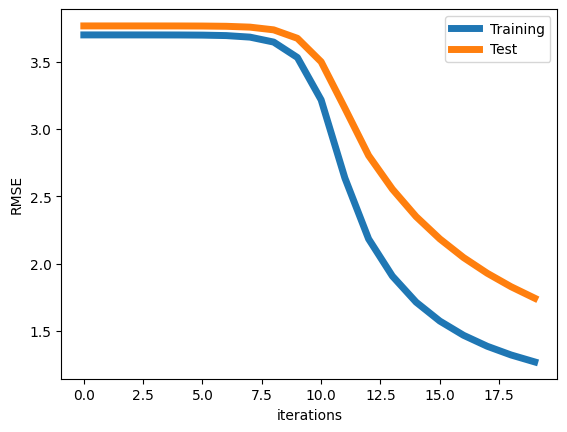

In [14]:
method = "gd"
gd = ExplicitMF(train, method=method)
start_time = time.time()
gd.training(test)
training_time = time.time() - start_time
print(f"--- {training_time} seconds ---")
metrics = gd.get_all_metrics(test)
results.append(
    [method] + list(dataclasses.astuple(metrics)) + [training_time]
)
plot_learning_curve(gd)

ALS model

	current iteration: 0
Iteration 0, Train RMSE: 1.7204297463660947, Test RMSE: 4.229824864468557
Iteration 1, Train RMSE: 0.7991296790224353, Test RMSE: 7.571588271729188
Iteration 2, Train RMSE: 0.7431985864307807, Test RMSE: 4.41570644644596
Iteration 3, Train RMSE: 0.7232627585565505, Test RMSE: 3.3532682936130014
Iteration 4, Train RMSE: 0.7122875103237052, Test RMSE: 3.1532984921285365
Iteration 5, Train RMSE: 0.7051641475909417, Test RMSE: 2.7083371824329343
Iteration 6, Train RMSE: 0.6999855452833375, Test RMSE: 1.8039525830833487
Iteration 7, Train RMSE: 0.6959793239968234, Test RMSE: 1.7436678429864045
Iteration 8, Train RMSE: 0.6927474972786756, Test RMSE: 1.7979206248756046
Iteration 9, Train RMSE: 0.6902165915890118, Test RMSE: 1.9178989948159213
	current iteration: 10
Iteration 10, Train RMSE: 0.6881751859824414, Test RMSE: 2.042645165216843
Iteration 11, Train RMSE: 0.6864319871614304, Test RMSE: 2.139671441281754
Iteration 12, Train RMSE: 0.6849110904196575, Test RMSE: 2.

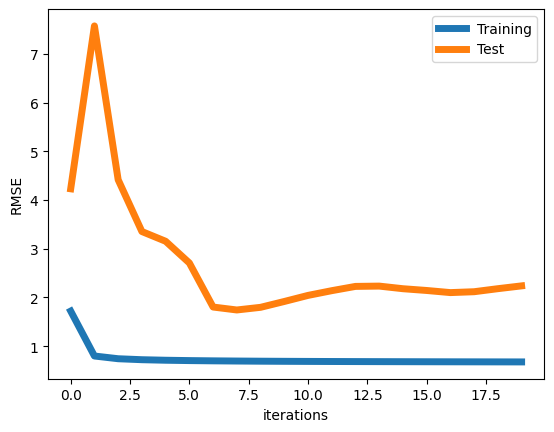

In [15]:
method = "als"
als = ExplicitMF(train, method=method)
start_time = time.time()
als.training(test)
training_time = time.time() - start_time
print(f"--- {training_time} seconds ---")
metrics = als.get_all_metrics(test)
results.append(
    [method] + list(dataclasses.astuple(metrics)) + [training_time]
)
plot_learning_curve(als)

Compare of the different models using various metrics

In [16]:
columns = [
    "RMSE training",
    "RMSE test",
    "MRR k=5 test",
    "MRR k=10 test",
    "Mean NDCG k=5 test",
    "Mean NDCG k=10 test",
    "MAP k=5 test",
    "MAP k=10 test",
    "Training time",
]


def results_to_dataframe(results: list) -> pd.DataFrame:
    """Prepares results for table.

    Args:
        results: results list.

    Returns:
        Results table.
    """

    results_pd = pd.DataFrame(results).set_index(0)
    results_pd = results_pd.set_index(results_pd.index.rename("Model / Metric"))
    results_pd.columns = columns
    return results_pd


lower_better = ["RMSE training", "RMSE test", "Training time"]
higher_better = list(set(columns) - set(lower_better))
results_pd = results_to_dataframe(results)
results_pd.style.background_gradient(
    "RdYlGn_r", axis=0, subset=lower_better,
).background_gradient("RdYlGn", axis=0, subset=higher_better)

,RMSE training,RMSE test,MRR k=5 test,MRR k=10 test,Mean NDCG k=5 test,Mean NDCG k=10 test,MAP k=5 test,MAP k=10 test,Training time
Model / Metric,,,,,,,,,
pop,3.135577,3.154388,0.254136,0.279259,0.111640,0.112609,0.244950,0.250991,5.421992
bias,2.954042,3.165551,0.251962,0.278270,0.116115,0.116542,0.242571,0.251680,4.550447
gd,1.270908,1.743852,0.159385,0.175621,0.077610,0.072700,0.158213,0.170913,145.189017
als,0.677808,2.238116,0.000566,0.001158,0.000331,0.000611,0.000566,0.001158,158.407466


### Hyperparameter tuning - ALS
Now that we have trained our models with the default hyperparameters, it's time to find their optimal values using grid search.

Factors: 5
iterations: 25
regularization: 0.001
	current iteration: 0
Iteration 0, Train RMSE: 1.8945949941593452, Test RMSE: 3.8010960915364858
Iteration 1, Train RMSE: 0.8691657072089793, Test RMSE: 1.9743736405835997
Iteration 2, Train RMSE: 0.821905214691892, Test RMSE: 1.550364409183026
Iteration 3, Train RMSE: 0.8075715900312189, Test RMSE: 1.9407230259030102
Iteration 4, Train RMSE: 0.800945542273298, Test RMSE: 1.6724204608421005
Iteration 5, Train RMSE: 0.797091515253932, Test RMSE: 1.8696615409409334
Iteration 6, Train RMSE: 0.794565052056376, Test RMSE: 1.8374577927737676
Iteration 7, Train RMSE: 0.7926792780489802, Test RMSE: 1.790799431473034
Iteration 8, Train RMSE: 0.7912168377713052, Test RMSE: 1.7382139614435086
Iteration 9, Train RMSE: 0.7899984484540367, Test RMSE: 1.6844510109638522
	current iteration: 10
Iteration 10, Train RMSE: 0.7889703619542664, Test RMSE: 1.6140470630051218
Iteration 11, Train RMSE: 0.7880291774448804, Test RMSE: 1.5911815370524809
Iteration 1

,RMSE training,RMSE test,MRR k=5 test,MRR k=10 test,Mean NDCG k=5 test,Mean NDCG k=10 test,MAP k=5 test,MAP k=10 test,Training time
Model / Metric,,,,,,,,,
pop,3.137317,3.139571,0.261665,0.284125,0.116868,0.113773,0.249929,0.254500,3.798242
bias,2.956139,3.149364,0.261559,0.283693,0.120350,0.117015,0.251546,0.256446,5.545071
gd,1.790716,1.921444,0.198975,0.202404,0.076628,0.058957,0.196359,0.198371,117.991625
als,0.679691,2.462054,0.002828,0.003005,0.001198,0.001170,0.002828,0.003005,130.532504
als_fact_5_reg_0.001_iter_25,0.781167,1.771572,0.000000,0.000402,0.000000,0.000239,0.000000,0.000402,161.148808
als_fact_5_reg_0.01_iter_25,0.780494,1.483002,0.001326,0.001772,0.000526,0.000710,0.001326,0.001772,159.888472
als_fact_5_reg_0.1_iter_25,0.775448,1.073903,0.000212,0.000672,0.000255,0.000465,0.000212,0.000672,159.366346


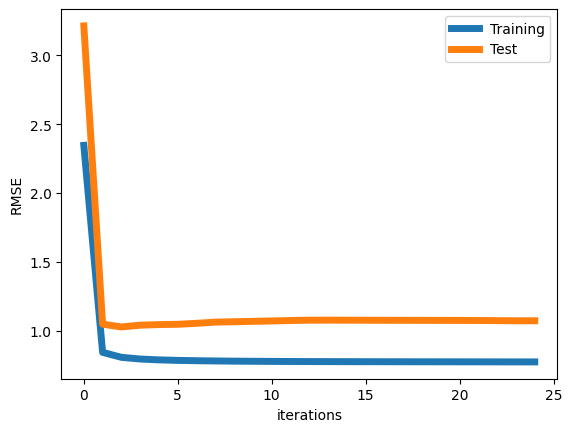

In [17]:
latent_factors = [5, 10, 20]
regularizations = [0.001, 0.01, 0.1]
iter_array = [25]

best_params = {}
best_params["n_factors"] = latent_factors[0]
best_params["reg"] = regularizations[0]
best_params["n_iter"] = iter_array[0]
best_params["train_rmse"] = np.inf
best_params["test_rmse"] = np.inf
best_params["model"] = None


for fact, n_iter, reg in itertools.product(
    latent_factors, iter_array, regularizations):
    print(f"Factors: {fact}")
    print(f"iterations: {n_iter}")
    print(f"regularization: {reg}")

    method = "als"
    model_name = "".join([
        method,
        "_fact_", str(fact),
        "_reg_", str(reg),
        "_iter_", str(n_iter)
    ])
    als_grid = ExplicitMF(
        train=train,
        method=method,
        n_factors=fact,
        n_iterations=n_iter,
        reg=reg,
    )
    start_time = time.time()
    als_grid.training(test)
    training_time = time.time() - start_time
    min_idx = np.argmin(als_grid.test_rmse)
    if als_grid.test_rmse[min_idx] >= best_params["test_rmse"]:
        continue

    metrics = als_grid.get_all_metrics(test)
    results.append(
        [model_name] + list(dataclasses.astuple(metrics)) + [training_time])
    best_params["n_factors"] = fact
    best_params["reg"] = reg
    best_params["n_iter"] = n_iter
    best_params["train_rmse"] = als_grid.train_rmse[min_idx]
    best_params["test_rmse"] = als_grid.test_rmse[min_idx]
    best_params["model"] = als_grid
    print("New optimal hyperparameters")
    print(pd.Series(best_params))
    print(f"--- {training_time} seconds ---")

best_als_model = best_params["model"]
plot_learning_curve(best_als_model)

results_pd = results_to_dataframe(results)
results_pd.style.background_gradient(
    "RdYlGn_r", axis=0, subset=lower_better,
).background_gradient("RdYlGn", axis=0, subset=higher_better)

---

#### Question 2 (10 points)

If there are any hyperparameters that could be further tuned (for example, if the best value for a hyperparameter is at the maximun of the grid scale), expand the grid search and continue the exploration. Make sure all your experiments are documented in the results table.

Which are the best hyperparameters for the ALS model?

Discuss your observations (overfitting, etc.)



``` Your response here ```

The general motivation is:
1. **Overfitting**:
* When n_factors is too large, the model may fit the training data too well, causing test RMSE to increase.
* Use regularization (reg) to reduce overfitting. Higher regularization reduces model complexity.

2. **Underfitting**:
* When n_factors is too small, the model may not capture enough patterns in the data, leading to poor performance on both train and test sets.

**Tradeoff Between Complexity and Regularization and Iteration Convergence**:
* Balancing n_factors and reg is critical. For example, increasing n_factors may require slightly higher reg to avoid overfitting
*  Monitor how test RMSE changes over iterations. If performance stabilizes early, you can stop training sooner to save time

Factors: 1
iterations: 10
regularization: 0.2
	current iteration: 0
Iteration 0, Train RMSE: 3.255202278542923, Test RMSE: 3.6021082398604594
Iteration 1, Train RMSE: 0.9703547354584625, Test RMSE: 1.1237774813444121
Iteration 2, Train RMSE: 0.914767907272004, Test RMSE: 0.9742435258011244
Iteration 3, Train RMSE: 0.9129087745587307, Test RMSE: 0.9707105660345074
Iteration 4, Train RMSE: 0.9129163943760354, Test RMSE: 0.9707488599645405
New optimal hyperparameters
n_factors                                                  1
reg                                                      0.2
n_iter                                                    10
train_rmse                                          0.912909
test_rmse                                           0.970711
model         <__main__.ExplicitMF object at 0x7ed6824e0460>
dtype: object
--- 31.02706241607666 seconds ---
Factors: 1
iterations: 10
regularization: 0.3
	current iteration: 0
Iteration 0, Train RMSE: 3.6040420275050318, Test

,RMSE training,RMSE test,MRR k=5 test,MRR k=10 test,Mean NDCG k=5 test,Mean NDCG k=10 test,MAP k=5 test,MAP k=10 test,Training time
Model / Metric,,,,,,,,,
pop,3.137317,3.139571,0.261665,0.284125,0.116868,0.113773,0.249929,0.254500,3.798242
bias,2.956139,3.149364,0.261559,0.283693,0.120350,0.117015,0.251546,0.256446,5.545071
gd,1.790716,1.921444,0.198975,0.202404,0.076628,0.058957,0.196359,0.198371,117.991625
als,0.679691,2.462054,0.002828,0.003005,0.001198,0.001170,0.002828,0.003005,130.532504
als_fact_5_reg_0.001_iter_25,0.781167,1.771572,0.000000,0.000402,0.000000,0.000239,0.000000,0.000402,161.148808
als_fact_5_reg_0.01_iter_25,0.780494,1.483002,0.001326,0.001772,0.000526,0.000710,0.001326,0.001772,159.888472
als_fact_5_reg_0.1_iter_25,0.775448,1.073903,0.000212,0.000672,0.000255,0.000465,0.000212,0.000672,159.366346
als_fact_1_reg_0.2_iter_10,0.912916,0.970749,0.000530,0.000636,0.000209,0.000215,0.000530,0.000636,31.027062
als_fact_1_reg_0.3_iter_10,0.912958,0.970855,0.000530,0.000648,0.000209,0.000218,0.000530,0.000648,45.200797


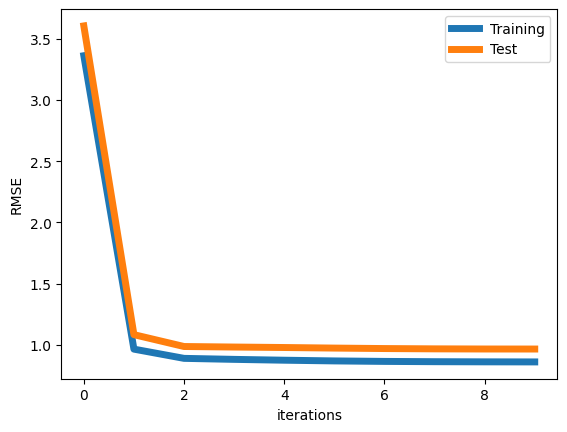

In [18]:
# latent_factors = [5, 10, 20]
# regularizations = [0.001, 0.01, 0.1]
# iter_array = [25]
latent_factors = [1,2,30,40]
regularizations = [0.2,0.3]
iter_array = [10]

best_params = {}
best_params["n_factors"] = latent_factors[0]
best_params["reg"] = regularizations[0]
best_params["n_iter"] = iter_array[0]
best_params["train_rmse"] = np.inf
best_params["test_rmse"] = np.inf
best_params["model"] = None


for fact, n_iter, reg in itertools.product(
    latent_factors, iter_array, regularizations):
    print(f"Factors: {fact}")
    print(f"iterations: {n_iter}")
    print(f"regularization: {reg}")

    method = "als"
    model_name = "".join([
        method,
        "_fact_", str(fact),
        "_reg_", str(reg),
        "_iter_", str(n_iter)
    ])
    als_grid = ExplicitMF(
        train=train,
        method=method,
        n_factors=fact,
        n_iterations=n_iter,
        reg=reg,
    )
    start_time = time.time()
    als_grid.training(test)
    training_time = time.time() - start_time
    min_idx = np.argmin(als_grid.test_rmse)
    if als_grid.test_rmse[min_idx] >= best_params["test_rmse"]:
        continue

    metrics = als_grid.get_all_metrics(test)
    results.append(
        [model_name] + list(dataclasses.astuple(metrics)) + [training_time])
    best_params["n_factors"] = fact
    best_params["reg"] = reg
    best_params["n_iter"] = n_iter
    best_params["train_rmse"] = als_grid.train_rmse[min_idx]
    best_params["test_rmse"] = als_grid.test_rmse[min_idx]
    best_params["model"] = als_grid
    print("New optimal hyperparameters")
    print(pd.Series(best_params))
    print(f"--- {training_time} seconds ---")

best_als_model = best_params["model"]
plot_learning_curve(best_als_model)

results_pd = results_to_dataframe(results)
results_pd.style.background_gradient(
    "RdYlGn_r", axis=0, subset=lower_better,
).background_gradient("RdYlGn", axis=0, subset=higher_better)

Factors: 50
iterations: 5
regularization: 0.1
	current iteration: 0
Iteration 0, Train RMSE: 1.086041669752093, Test RMSE: 2.807152141741616
Iteration 1, Train RMSE: 0.4732416573055506, Test RMSE: 1.573976431111754
Iteration 2, Train RMSE: 0.3956238972427145, Test RMSE: 1.5727475658300292
Iteration 3, Train RMSE: 0.35718339160969625, Test RMSE: 1.598353016951229
Iteration 4, Train RMSE: 0.332718541624264, Test RMSE: 1.6256286816851748
New optimal hyperparameters
n_factors                                                 50
reg                                                      0.1
n_iter                                                     5
train_rmse                                          0.395624
test_rmse                                           1.572748
model         <__main__.ExplicitMF object at 0x7ed683323be0>
dtype: object
--- 37.75760245323181 seconds ---
Factors: 50
iterations: 5
regularization: 0.01
	current iteration: 0
Iteration 0, Train RMSE: 0.9043783879024803, Test 

,RMSE training,RMSE test,MRR k=5 test,MRR k=10 test,Mean NDCG k=5 test,Mean NDCG k=10 test,MAP k=5 test,MAP k=10 test,Training time
Model / Metric,,,,,,,,,
pop,3.137317,3.139571,0.261665,0.284125,0.116868,0.113773,0.249929,0.254500,3.798242
bias,2.956139,3.149364,0.261559,0.283693,0.120350,0.117015,0.251546,0.256446,5.545071
gd,1.790716,1.921444,0.198975,0.202404,0.076628,0.058957,0.196359,0.198371,117.991625
als,0.679691,2.462054,0.002828,0.003005,0.001198,0.001170,0.002828,0.003005,130.532504
als_fact_5_reg_0.001_iter_25,0.781167,1.771572,0.000000,0.000402,0.000000,0.000239,0.000000,0.000402,161.148808
als_fact_5_reg_0.01_iter_25,0.780494,1.483002,0.001326,0.001772,0.000526,0.000710,0.001326,0.001772,159.888472
als_fact_5_reg_0.1_iter_25,0.775448,1.073903,0.000212,0.000672,0.000255,0.000465,0.000212,0.000672,159.366346
als_fact_1_reg_0.2_iter_10,0.912916,0.970749,0.000530,0.000636,0.000209,0.000215,0.000530,0.000636,31.027062
als_fact_1_reg_0.3_iter_10,0.912958,0.970855,0.000530,0.000648,0.000209,0.000218,0.000530,0.000648,45.200797


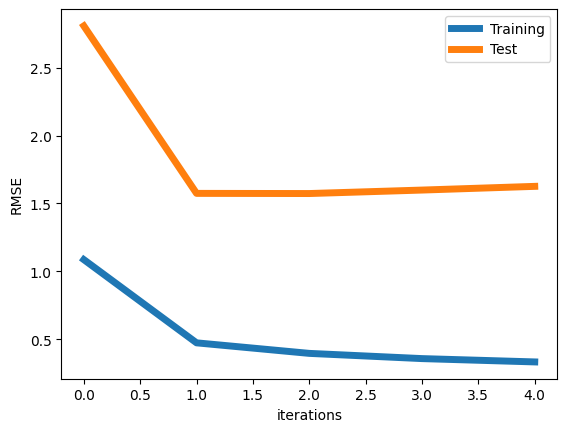

In [19]:
# latent_factors = [5, 10, 20]
# regularizations = [0.001, 0.01, 0.1]
# iter_array = [25]
latent_factors = [50,80]
regularizations = [0.1,0.01]
iter_array = [5]

best_params = {}
best_params["n_factors"] = latent_factors[0]
best_params["reg"] = regularizations[0]
best_params["n_iter"] = iter_array[0]
best_params["train_rmse"] = np.inf
best_params["test_rmse"] = np.inf
best_params["model"] = None


for fact, n_iter, reg in itertools.product(
    latent_factors, iter_array, regularizations):
    print(f"Factors: {fact}")
    print(f"iterations: {n_iter}")
    print(f"regularization: {reg}")

    method = "als"
    model_name = "".join([
        method,
        "_fact_", str(fact),
        "_reg_", str(reg),
        "_iter_", str(n_iter)
    ])
    als_grid = ExplicitMF(
        train=train,
        method=method,
        n_factors=fact,
        n_iterations=n_iter,
        reg=reg,
    )
    start_time = time.time()
    als_grid.training(test)
    training_time = time.time() - start_time
    min_idx = np.argmin(als_grid.test_rmse)
    if als_grid.test_rmse[min_idx] >= best_params["test_rmse"]:
        continue

    metrics = als_grid.get_all_metrics(test)
    results.append(
        [model_name] + list(dataclasses.astuple(metrics)) + [training_time])
    best_params["n_factors"] = fact
    best_params["reg"] = reg
    best_params["n_iter"] = n_iter
    best_params["train_rmse"] = als_grid.train_rmse[min_idx]
    best_params["test_rmse"] = als_grid.test_rmse[min_idx]
    best_params["model"] = als_grid
    print("New optimal hyperparameters")
    print(pd.Series(best_params))
    print(f"--- {training_time} seconds ---")

best_als_model = best_params["model"]
plot_learning_curve(best_als_model)

results_pd = results_to_dataframe(results)
results_pd.style.background_gradient(
    "RdYlGn_r", axis=0, subset=lower_better,
).background_gradient("RdYlGn", axis=0, subset=higher_better)

Factors: 5
iterations: 40
regularization: 0.1
	current iteration: 0
Iteration 0, Train RMSE: 3.1100681785323787, Test RMSE: 3.5452249859319203
Iteration 1, Train RMSE: 0.9698622285136944, Test RMSE: 1.2452693832494521
Iteration 2, Train RMSE: 0.8286903504081785, Test RMSE: 1.0652113588868324
Iteration 3, Train RMSE: 0.8063297307316599, Test RMSE: 1.0378073905399867
Iteration 4, Train RMSE: 0.7962890014990059, Test RMSE: 1.0381324222692645
Iteration 5, Train RMSE: 0.790762270612465, Test RMSE: 1.0425534901764468
Iteration 6, Train RMSE: 0.7871881559617587, Test RMSE: 1.04907342152532
Iteration 7, Train RMSE: 0.7848292232030503, Test RMSE: 1.0564292963588575
Iteration 8, Train RMSE: 0.7830659066919312, Test RMSE: 1.064000350584226
Iteration 9, Train RMSE: 0.7817602757362206, Test RMSE: 1.0688939058647182
	current iteration: 10
Iteration 10, Train RMSE: 0.7807484675754248, Test RMSE: 1.0705677094035235
Iteration 11, Train RMSE: 0.7799671777915841, Test RMSE: 1.0716369412420037
Iteration 1

,RMSE training,RMSE test,MRR k=5 test,MRR k=10 test,Mean NDCG k=5 test,Mean NDCG k=10 test,MAP k=5 test,MAP k=10 test,Training time
Model / Metric,,,,,,,,,
pop,3.137317,3.139571,0.261665,0.284125,0.116868,0.113773,0.249929,0.254500,3.798242
bias,2.956139,3.149364,0.261559,0.283693,0.120350,0.117015,0.251546,0.256446,5.545071
gd,1.790716,1.921444,0.198975,0.202404,0.076628,0.058957,0.196359,0.198371,117.991625
als,0.679691,2.462054,0.002828,0.003005,0.001198,0.001170,0.002828,0.003005,130.532504
als_fact_5_reg_0.001_iter_25,0.781167,1.771572,0.000000,0.000402,0.000000,0.000239,0.000000,0.000402,161.148808
als_fact_5_reg_0.01_iter_25,0.780494,1.483002,0.001326,0.001772,0.000526,0.000710,0.001326,0.001772,159.888472
als_fact_5_reg_0.1_iter_25,0.775448,1.073903,0.000212,0.000672,0.000255,0.000465,0.000212,0.000672,159.366346
als_fact_1_reg_0.2_iter_10,0.912916,0.970749,0.000530,0.000636,0.000209,0.000215,0.000530,0.000636,31.027062
als_fact_1_reg_0.3_iter_10,0.912958,0.970855,0.000530,0.000648,0.000209,0.000218,0.000530,0.000648,45.200797


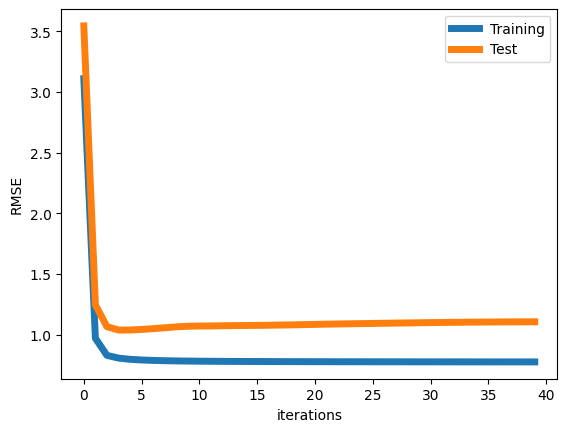

In [20]:
# latent_factors = [5, 10, 20]
# regularizations = [0.001, 0.01, 0.1]
# iter_array = [25]
latent_factors = [5]
regularizations = [0.1,0.01]
iter_array = [40]

best_params = {}
best_params["n_factors"] = latent_factors[0]
best_params["reg"] = regularizations[0]
best_params["n_iter"] = iter_array[0]
best_params["train_rmse"] = np.inf
best_params["test_rmse"] = np.inf
best_params["model"] = None


for fact, n_iter, reg in itertools.product(
    latent_factors, iter_array, regularizations):
    print(f"Factors: {fact}")
    print(f"iterations: {n_iter}")
    print(f"regularization: {reg}")

    method = "als"
    model_name = "".join([
        method,
        "_fact_", str(fact),
        "_reg_", str(reg),
        "_iter_", str(n_iter)
    ])
    als_grid = ExplicitMF(
        train=train,
        method=method,
        n_factors=fact,
        n_iterations=n_iter,
        reg=reg,
    )
    start_time = time.time()
    als_grid.training(test)
    training_time = time.time() - start_time
    min_idx = np.argmin(als_grid.test_rmse)
    if als_grid.test_rmse[min_idx] >= best_params["test_rmse"]:
        continue

    metrics = als_grid.get_all_metrics(test)
    results.append(
        [model_name] + list(dataclasses.astuple(metrics)) + [training_time])
    best_params["n_factors"] = fact
    best_params["reg"] = reg
    best_params["n_iter"] = n_iter
    best_params["train_rmse"] = als_grid.train_rmse[min_idx]
    best_params["test_rmse"] = als_grid.test_rmse[min_idx]
    best_params["model"] = als_grid
    print("New optimal hyperparameters")
    print(pd.Series(best_params))
    print(f"--- {training_time} seconds ---")

best_als_model = best_params["model"]
plot_learning_curve(best_als_model)

results_pd = results_to_dataframe(results)
results_pd.style.background_gradient(
    "RdYlGn_r", axis=0, subset=lower_better,
).background_gradient("RdYlGn", axis=0, subset=higher_better)

Factors: 10
iterations: 15
regularization: 0.5
	current iteration: 0
Iteration 0, Train RMSE: 2.0647207194498596, Test RMSE: 2.8565292588951934
Iteration 1, Train RMSE: 0.7735166744256361, Test RMSE: 1.0948888147780698
Iteration 2, Train RMSE: 0.7246921451952623, Test RMSE: 1.0966626318238726
Iteration 3, Train RMSE: 0.7073744269354685, Test RMSE: 1.105660235702077
Iteration 4, Train RMSE: 0.6984033479819673, Test RMSE: 1.1092174784666857
Iteration 5, Train RMSE: 0.692858531658769, Test RMSE: 1.1112666174354757
Iteration 6, Train RMSE: 0.6890865216295256, Test RMSE: 1.1131462895777064
Iteration 7, Train RMSE: 0.6864151747960273, Test RMSE: 1.1147855519497165
Iteration 8, Train RMSE: 0.684452662367411, Test RMSE: 1.1162558751382061
Iteration 9, Train RMSE: 0.6829576985320573, Test RMSE: 1.1175581730979967
	current iteration: 10
Iteration 10, Train RMSE: 0.6817846464764267, Test RMSE: 1.1186147562988624
Iteration 11, Train RMSE: 0.6808382704503828, Test RMSE: 1.1193392905363366
Iteration

,RMSE training,RMSE test,MRR k=5 test,MRR k=10 test,Mean NDCG k=5 test,Mean NDCG k=10 test,MAP k=5 test,MAP k=10 test,Training time
Model / Metric,,,,,,,,,
pop,3.137317,3.139571,0.261665,0.284125,0.116868,0.113773,0.249929,0.254500,3.798242
bias,2.956139,3.149364,0.261559,0.283693,0.120350,0.117015,0.251546,0.256446,5.545071
gd,1.790716,1.921444,0.198975,0.202404,0.076628,0.058957,0.196359,0.198371,117.991625
als,0.679691,2.462054,0.002828,0.003005,0.001198,0.001170,0.002828,0.003005,130.532504
als_fact_5_reg_0.001_iter_25,0.781167,1.771572,0.000000,0.000402,0.000000,0.000239,0.000000,0.000402,161.148808
als_fact_5_reg_0.01_iter_25,0.780494,1.483002,0.001326,0.001772,0.000526,0.000710,0.001326,0.001772,159.888472
als_fact_5_reg_0.1_iter_25,0.775448,1.073903,0.000212,0.000672,0.000255,0.000465,0.000212,0.000672,159.366346
als_fact_1_reg_0.2_iter_10,0.912916,0.970749,0.000530,0.000636,0.000209,0.000215,0.000530,0.000636,31.027062
als_fact_1_reg_0.3_iter_10,0.912958,0.970855,0.000530,0.000648,0.000209,0.000218,0.000530,0.000648,45.200797


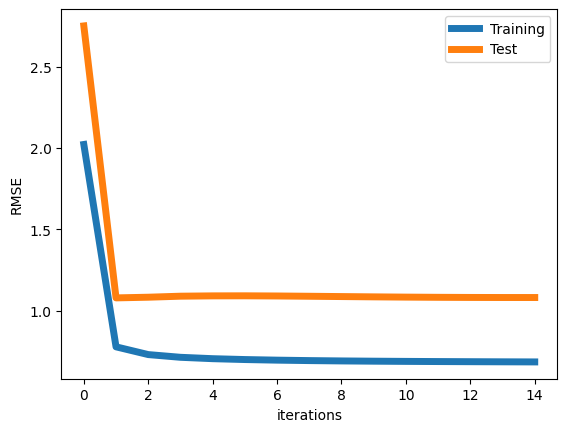

In [26]:
# latent_factors = [5, 10, 20]
# regularizations = [0.001, 0.01, 0.1]
# iter_array = [25]
latent_factors = [10]
regularizations = [0.5,0.8]
iter_array = [15]

best_params = {}
best_params["n_factors"] = latent_factors[0]
best_params["reg"] = regularizations[0]
best_params["n_iter"] = iter_array[0]
best_params["train_rmse"] = np.inf
best_params["test_rmse"] = np.inf
best_params["model"] = None


for fact, n_iter, reg in itertools.product(
    latent_factors, iter_array, regularizations):
    print(f"Factors: {fact}")
    print(f"iterations: {n_iter}")
    print(f"regularization: {reg}")

    method = "als"
    model_name = "".join([
        method,
        "_fact_", str(fact),
        "_reg_", str(reg),
        "_iter_", str(n_iter)
    ])
    als_grid = ExplicitMF(
        train=train,
        method=method,
        n_factors=fact,
        n_iterations=n_iter,
        reg=reg,
    )
    start_time = time.time()
    als_grid.training(test)
    training_time = time.time() - start_time
    min_idx = np.argmin(als_grid.test_rmse)
    if als_grid.test_rmse[min_idx] >= best_params["test_rmse"]:
        continue

    metrics = als_grid.get_all_metrics(test)
    results.append(
        [model_name] + list(dataclasses.astuple(metrics)) + [training_time])
    best_params["n_factors"] = fact
    best_params["reg"] = reg
    best_params["n_iter"] = n_iter
    best_params["train_rmse"] = als_grid.train_rmse[min_idx]
    best_params["test_rmse"] = als_grid.test_rmse[min_idx]
    best_params["model"] = als_grid
    print("New optimal hyperparameters")
    print(pd.Series(best_params))
    print(f"--- {training_time} seconds ---")

best_als_model = best_params["model"]
plot_learning_curve(best_als_model)

results_pd = results_to_dataframe(results)
results_pd.style.background_gradient(
    "RdYlGn_r", axis=0, subset=lower_better,
).background_gradient("RdYlGn", axis=0, subset=higher_better)

In our case:
1. **Best Model**:<br> Model - als_fact_1_reg_0.2_iter_10, Train RMSE: 0.912916, Test RMSE: 0.970749. This configuration balances train and test RMSE, indicating a good generalization capability. Simple configuration (fewer factors and iterations) performs better and run faster than larger models.

2. **Worst Generalization (overfitting)**:<br>
Model - als_fact_60_reg_0.5_iter_15, Train RMSE: 0.184618, Test RMSE: 1.346376.
While it fits the training data exceptionally well, it fails to generalize to test data due to excessive complexity.

3. **Observations**:
* Increasing n_factors captures more complex patterns in the data but risks overfitting
* Regularization helps reduce overfitting, but too much can lead to underfitting
* Fewer iterations may underfit, while too many can increase runtime without improving performance
* In our case simpler models generalize better and run faster, while more complex models only add computational cost without improving results.

---

### Hyperparameter tuning - GD


#### Question 3 (15 points)
Repeat the process of grid search for the gradient descent model.
Don't forget to include also learning rate optimization. Make sure all your experiments are documented in the results table.


In [17]:
# Your code here

best_gd_model = None

Factors: 10
iterations: 20
regularization: 0.001
learning_rate: 0.001
	current iteration: 0
Iteration 0, Train RMSE: 3.6994723314150173, Test RMSE: 3.757649839711957
Iteration 1, Train RMSE: 3.699461660897669, Test RMSE: 3.757648128252382
Iteration 2, Train RMSE: 3.6994390432589017, Test RMSE: 3.7576396709179383
Iteration 3, Train RMSE: 3.6993772263132856, Test RMSE: 3.757609300998872
Iteration 4, Train RMSE: 3.6991872468007605, Test RMSE: 3.7575077926073224
Iteration 5, Train RMSE: 3.698577086336073, Test RMSE: 3.7571742244449498
Iteration 6, Train RMSE: 3.6965879181655503, Test RMSE: 3.7560816790353555
Iteration 7, Train RMSE: 3.690080911123933, Test RMSE: 3.752508225200503
Iteration 8, Train RMSE: 3.6688952611732244, Test RMSE: 3.7408839032668513
Iteration 9, Train RMSE: 3.6013643038090173, Test RMSE: 3.70383075619687
	current iteration: 10
Iteration 10, Train RMSE: 3.401002308980826, Test RMSE: 3.593469840666541
Iteration 11, Train RMSE: 2.9305172037802145, Test RMSE: 3.32744417038

,RMSE training,RMSE test,MRR k=5 test,MRR k=10 test,Mean NDCG k=5 test,Mean NDCG k=10 test,MAP k=5 test,MAP k=10 test,Training time
Model / Metric,,,,,,,,,
pop,3.136703,3.143320,0.274744,0.297819,0.120209,0.116486,0.263559,0.263305,6.245615
bias,2.955119,3.155073,0.271598,0.296235,0.122910,0.120703,0.260893,0.263233,5.193433
gd,1.321552,1.824572,0.179180,0.194790,0.084605,0.078647,0.173957,0.184915,140.897341
als,0.677761,1.658778,0.001273,0.001910,0.000451,0.000633,0.001273,0.001910,158.665256
gd_fact_10_reg_0.001_iter_20_lr_0.001,1.295364,1.779740,0.173206,0.189402,0.082251,0.077076,0.169335,0.180553,138.828318


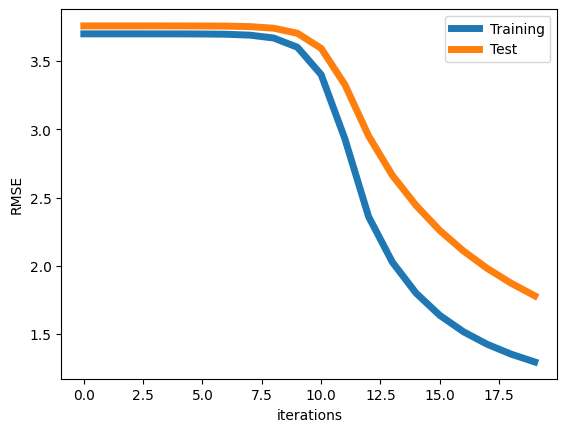

In [18]:
latent_factors = [10]
regularizations = [0.001]
iter_array = [20]
learning_rates = [0.001]

best_params = {}
best_params["n_factors"] = latent_factors[0]
best_params["reg"] = regularizations[0]
best_params["n_iter"] = iter_array[0]
best_params["lr"] = learning_rates[0]
best_params["train_rmse"] = np.inf
best_params["test_rmse"] = np.inf
best_params["model"] = None


for fact, n_iter, reg, lr in itertools.product(
    latent_factors, iter_array, regularizations,learning_rates):
    print(f"Factors: {fact}")
    print(f"iterations: {n_iter}")
    print(f"regularization: {reg}"),
    print(f"learning_rate: {lr}")

    method = "gd"
    model_name = "".join([
        method,
        "_fact_", str(fact),
        "_reg_", str(reg),
        "_iter_", str(n_iter),
        "_lr_",str(lr),
    ])
    gd_grid = ExplicitMF(
        train=train,
        method=method,
        n_factors=fact,
        n_iterations=n_iter,
        reg=reg,
        learning_rate=lr,
    )
    start_time = time.time()
    gd_grid.training(test)
    training_time = time.time() - start_time
    min_idx = np.argmin(gd_grid.test_rmse)
    if gd_grid.test_rmse[min_idx] >= best_params["test_rmse"]:
        continue

    metrics = gd_grid.get_all_metrics(test)
    results.append(
        [model_name] + list(dataclasses.astuple(metrics)) + [training_time])
    best_params["n_factors"] = fact
    best_params["reg"] = reg
    best_params["n_iter"] = n_iter
    best_params["lr"] = lr
    best_params["train_rmse"] = gd_grid.train_rmse[min_idx]
    best_params["test_rmse"] = gd_grid.test_rmse[min_idx]
    best_params["model"] = gd_grid
    print("New optimal hyperparameters")
    print(pd.Series(best_params))
    print(f"--- {training_time} seconds ---")

best_gd_model = best_params["model"]
plot_learning_curve(best_gd_model)

results_pd = results_to_dataframe(results)
results_pd.style.background_gradient(
    "RdYlGn_r", axis=0, subset=lower_better,
).background_gradient("RdYlGn", axis=0, subset=higher_better)

Factors: 5
iterations: 20
regularization: 0.001
learning_rate: 0.001
	current iteration: 0
Iteration: 1
[[-0.00798279 -0.00088283 -0.0078227  -0.0086464  -0.00459748]
 [ 0.00572592 -0.0022361   0.01230762 -0.01147274  0.00531695]
 [ 0.01170148  0.00672858 -0.01481128 -0.00383787 -0.00090104]
 ...
 [-0.0049323  -0.00433319  0.00014728  0.00220332  0.00818265]
 [-0.01589282 -0.01161181  0.00098609  0.00077855 -0.00832023]
 [-0.00065937 -0.00220666  0.00648915  0.01410799 -0.01578811]]
Iteration 0, Train RMSE: 3.701248085027891, Test RMSE: 3.7408228375583006
Iteration: 2
[[-7.58372667e-03 -1.30387541e-03 -8.23752736e-03 -9.27860825e-03
  -4.59635231e-03]
 [ 5.67114866e-03 -2.38639448e-03  1.22935425e-02 -1.15905427e-02
   5.14602945e-03]
 [ 1.19454024e-02  6.34355774e-03 -1.49084899e-02 -3.76045109e-03
  -6.32259476e-04]
 ...
 [-4.79372945e-03 -4.59713670e-03 -3.27349899e-05  2.08753653e-03
   8.07827365e-03]
 [-1.62472940e-02 -1.12118660e-02  1.11502238e-03  9.73307499e-04
  -8.77635233e

<ipython-input-25-8961df6a2c54>:285: RuntimeWarning: overflow encountered in square
  rmse = np.sqrt(np.mean((actual_non_zeros - preds)**2))


Iteration 5, Train RMSE: inf, Test RMSE: inf
Iteration: 7
[[-1.10871860e+87 -3.80815231e+86  8.13591717e+86  1.06722326e+87
  -3.33536591e+86]
 [-7.51866284e+83 -2.58244780e+83  5.51726854e+83  7.23727147e+83
  -2.26185919e+83]
 [-4.03944248e+82 -1.38743436e+82  2.96418251e+82  3.88826225e+82
  -1.21519514e+82]
 ...
 [-3.24757682e+82 -1.11543542e+82  2.38307453e+82  3.12603629e+82
  -9.76990295e+81]
 [-1.76741692e+85 -6.07062639e+84  1.29695707e+85  1.70126823e+85
  -5.31691210e+84]
 [-3.19828186e+86 -1.09852348e+86  2.34693773e+86  3.07858174e+86
  -9.62142213e+85]]


<ipython-input-25-8961df6a2c54>:122: RuntimeWarning: overflow encountered in matmul
  U += self.learning_rate * ((errors @ V) - (self.reg * U))
<ipython-input-25-8961df6a2c54>:123: RuntimeWarning: invalid value encountered in matmul
  V += self.learning_rate * ((errors.T @ U) - (self.reg * V))


Streaming output truncated to the last 5000 lines.
   1.07731175e-02  1.85568352e-02]
 [-3.19086865e-04  5.30495560e-03 -1.06542617e-02 ...  1.48448357e-02
   1.28443546e-02  7.63062137e-03]
 ...
 [ 7.36943702e-03  8.86707911e-03  2.16098318e-04 ...  2.16209797e-02
   9.70641615e-03  1.82895793e-02]
 [-6.53883060e-02  4.62499708e-02  1.91129629e-02 ...  8.34383831e-02
   4.91565308e-02 -8.05731982e-03]
 [-1.13554714e-01  6.33561236e-02  3.43882440e-02 ...  1.93158994e-01
   7.59358221e-02  2.89005612e-02]]
Iteration 10, Train RMSE: 3.362336284463846, Test RMSE: 3.5563466612095134
Iteration: 12
[[-2.39577014e-01  1.72171360e-01  8.60203415e-02 ...  5.02860696e-01
   2.29543327e-01  5.07549165e-02]
 [-2.83886965e-02  2.96459675e-02  2.00530695e-02 ...  9.58849966e-02
   2.96793520e-02  2.13604239e-02]
 [-7.48662060e-03  1.20729591e-02 -7.78584715e-03 ...  3.05750582e-02
   2.09526619e-02  8.33682402e-03]
 ...
 [ 3.00767965e-04  1.48610042e-02  2.91762190e-03 ...  3.68427323e-02
   1.7349

KeyError: '`Styler.apply` and `.map` are not compatible with non-unique index or columns.'

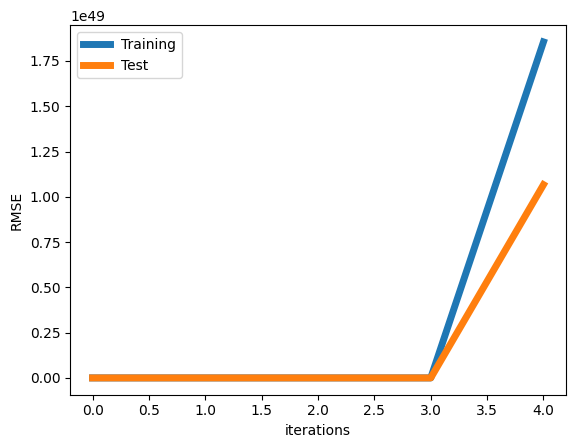

In [27]:
latent_factors = [5, 10, 20]
regularizations = [0.001, 0.01, 0.1]
iter_array = [20]
learning_rates = [0.001, 0.0001, 0.01]

best_params = {}
best_params["n_factors"] = latent_factors[0]
best_params["reg"] = regularizations[0]
best_params["n_iter"] = iter_array[0]
best_params["train_rmse"] = np.inf
best_params["test_rmse"] = np.inf
best_params["model"] = None


for fact, n_iter, reg, lr in itertools.product(
    latent_factors, iter_array, regularizations,learning_rates):
    print(f"Factors: {fact}")
    print(f"iterations: {n_iter}")
    print(f"regularization: {reg}"),
    print(f"learning_rate: {lr}")

    method = "gd"
    model_name = "".join([
        method,
        "_fact_", str(fact),
        "_reg_", str(reg),
        "_iter_", str(n_iter),
        "_lr_",str(lr),
    ])
    gd_grid = ExplicitMF(
        train=train,
        method=method,
        n_factors=fact,
        n_iterations=n_iter,
        reg=reg,
        learning_rate=lr,
    )
    start_time = time.time()
    gd_grid.training(test)
    training_time = time.time() - start_time
    min_idx = np.argmin(gd_grid.test_rmse)
    if gd_grid.test_rmse[min_idx] >= best_params["test_rmse"]:
        continue

    metrics = gd_grid.get_all_metrics(test)
    results.append(
        [model_name] + list(dataclasses.astuple(metrics)) + [training_time])
    best_params["n_factors"] = fact
    best_params["reg"] = reg
    best_params["n_iter"] = n_iter
    best_params["learning_rate"] = lr
    best_params["train_rmse"] = gd_grid.train_rmse[min_idx]
    best_params["test_rmse"] = gd_grid.test_rmse[min_idx]
    best_params["model"] = gd_grid
    print("New optimal hyperparameters")
    print(pd.Series(best_params))
    print(f"--- {training_time} seconds ---")

best_gd_model = best_params["model"]
plot_learning_curve(best_gd_model)

results_pd = results_to_dataframe(results)
results_pd.style.background_gradient(
    "RdYlGn_r", axis=0, subset=lower_better,
).background_gradient("RdYlGn", axis=0, subset=higher_better)

Factors: 10
iterations: 50
regularization: 0.001
learning_rate: 0.0001
	current iteration: 0
Iteration: 1
[[ 0.00600508 -0.00765084  0.00536079 ... -0.01143202 -0.0039908
   0.00837464]
 [-0.00467578  0.00339553  0.00575824 ... -0.00523858 -0.01554211
  -0.01122516]
 [ 0.00555725  0.01490141  0.01902934 ...  0.00557703 -0.00782234
   0.0223725 ]
 ...
 [-0.00294253 -0.00132606 -0.00278945 ... -0.01177748 -0.00434312
  -0.00956969]
 [ 0.01042972  0.00898766  0.00399658 ...  0.00344584  0.00199563
  -0.0086884 ]
 [ 0.00355493 -0.01247959  0.00838681 ... -0.01101876  0.00538858
   0.01948062]]
Iteration 0, Train RMSE: 3.698263705127518, Test RMSE: 3.7691027636139296
Iteration: 2
[[ 0.00587979 -0.00767837  0.00534444 ... -0.01139045 -0.00388167
   0.00830707]
 [-0.0046682   0.00346115  0.00574044 ... -0.00525603 -0.01552339
  -0.01121882]
 [ 0.00559187  0.01494377  0.01903223 ...  0.00562295 -0.00785564
   0.02238911]
 ...
 [-0.00293068 -0.00130019 -0.00280985 ... -0.01177068 -0.00434445
  

,RMSE training,RMSE test,MRR k=5 test,MRR k=10 test,Mean NDCG k=5 test,Mean NDCG k=10 test,MAP k=5 test,MAP k=10 test,Training time
Model / Metric,,,,,,,,,
pop,3.136820,3.149080,0.270113,0.289745,0.116940,0.114835,0.256304,0.250318,1.757337
bias,2.954830,3.162426,0.262973,0.287045,0.119098,0.121382,0.251417,0.250013,5.789634
gd,1.269532,1.744437,0.162566,0.180684,0.076866,0.074409,0.161986,0.174005,142.396229
als,0.680239,2.654498,0.000954,0.001459,0.000751,0.000864,0.000954,0.001459,163.240121
gd_fact_10_reg_0.001_iter_20_lr_0.0001,3.698244,3.769107,0.014051,0.018806,0.006342,0.007698,0.014051,0.018825,140.757507
gd_fact_10_reg_0.001_iter_50_lr_0.0001,3.697446,3.768669,0.137946,0.151528,0.058631,0.057251,0.134123,0.139248,351.371239


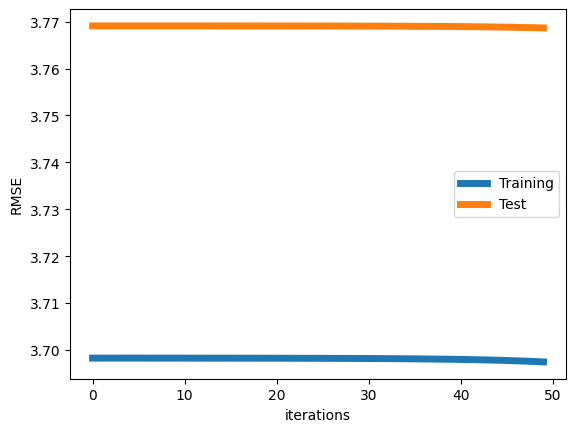

In [40]:
latent_factors = [10]
regularizations = [0.001]
iter_array = [50]
learning_rates = [0.0001]

best_params = {}
best_params["n_factors"] = latent_factors[0]
best_params["reg"] = regularizations[0]
best_params["n_iter"] = iter_array[0]
best_params["lr"] = learning_rates[0]
best_params["train_rmse"] = np.inf
best_params["test_rmse"] = np.inf
best_params["model"] = None


for fact, n_iter, reg, lr in itertools.product(
    latent_factors, iter_array, regularizations,learning_rates):
    print(f"Factors: {fact}")
    print(f"iterations: {n_iter}")
    print(f"regularization: {reg}"),
    print(f"learning_rate: {lr}")

    method = "gd"
    model_name = "".join([
        method,
        "_fact_", str(fact),
        "_reg_", str(reg),
        "_iter_", str(n_iter),
        "_lr_",str(lr),
    ])
    gd_grid = ExplicitMF(
        train=train,
        method=method,
        n_factors=fact,
        n_iterations=n_iter,
        reg=reg,
        learning_rate=lr,
    )
    start_time = time.time()
    gd_grid.training(test)
    training_time = time.time() - start_time
    min_idx = np.argmin(gd_grid.test_rmse)
    if gd_grid.test_rmse[min_idx] >= best_params["test_rmse"]:
        continue

    metrics = gd_grid.get_all_metrics(test)
    results.append(
        [model_name] + list(dataclasses.astuple(metrics)) + [training_time])
    best_params["n_factors"] = fact
    best_params["reg"] = reg
    best_params["n_iter"] = n_iter
    best_params["lr"] = lr
    best_params["train_rmse"] = gd_grid.train_rmse[min_idx]
    best_params["test_rmse"] = gd_grid.test_rmse[min_idx]
    best_params["model"] = gd_grid
    print("New optimal hyperparameters")
    print(pd.Series(best_params))
    print(f"--- {training_time} seconds ---")

best_gd_model = best_params["model"]
plot_learning_curve(best_gd_model)

results_pd = results_to_dataframe(results)
results_pd.style.background_gradient(
    "RdYlGn_r", axis=0, subset=lower_better,
).background_gradient("RdYlGn", axis=0, subset=higher_better)

Factors: 40
iterations: 300
regularization: 0.01
learning_rate: 0.0001
	current iteration: 0
Iteration: 1
[[-0.00968683  0.01158743 -0.00493294 ... -0.00399928  0.01181185
   0.00616646]
 [ 0.01301603 -0.01213642 -0.01404504 ...  0.00635756  0.01054398
   0.00722945]
 [-0.00847353  0.0117498   0.00239665 ...  0.01296779  0.00036258
  -0.00876506]
 ...
 [ 0.0024415  -0.00426321  0.01478872 ...  0.01409456  0.00668654
  -0.01529201]
 [-0.00841437 -0.02307989  0.00318944 ... -0.00545426 -0.02597773
   0.01331339]
 [ 0.00331098  0.00558176 -0.01571116 ... -0.00773529  0.00134721
   0.00551764]]
Iteration 0, Train RMSE: 3.6982616207860373, Test RMSE: 3.76908995859064
Iteration: 2
[[-0.00965135  0.01162974 -0.00495164 ... -0.00409165  0.0118536
   0.00614658]
 [ 0.01301209 -0.01209786 -0.01403486 ...  0.00635805  0.0105325
   0.00723442]
 [-0.00849646  0.01172918  0.0023905  ...  0.01295592  0.00036375
  -0.00876814]
 ...
 [ 0.00242023 -0.00425659  0.01479948 ...  0.01408815  0.00667866
  -0

,RMSE training,RMSE test,MRR k=5 test,MRR k=10 test,Mean NDCG k=5 test,Mean NDCG k=10 test,MAP k=5 test,MAP k=10 test,Training time
Model / Metric,,,,,,,,,
pop,3.136820,3.149080,0.270113,0.289745,0.116940,0.114835,0.256304,0.250318,1.757337
bias,2.954830,3.162426,0.262973,0.287045,0.119098,0.121382,0.251417,0.250013,5.789634
gd,1.269532,1.744437,0.162566,0.180684,0.076866,0.074409,0.161986,0.174005,142.396229
als,0.680239,2.654498,0.000954,0.001459,0.000751,0.000864,0.000954,0.001459,163.240121
gd_fact_10_reg_0.001_iter_20_lr_0.0001,3.698244,3.769107,0.014051,0.018806,0.006342,0.007698,0.014051,0.018825,140.757507
gd_fact_10_reg_0.001_iter_50_lr_0.0001,3.697446,3.768669,0.137946,0.151528,0.058631,0.057251,0.134123,0.139248,351.371239
gd_fact_40_reg_0.01_iter_50_lr_0.0001,3.696438,3.768189,0.142382,0.156021,0.061647,0.059658,0.138912,0.145341,356.812690
gd_fact_40_reg_0.01_iter_300_lr_0.0001,1.041666,1.322426,0.099806,0.117363,0.049021,0.051404,0.098088,0.111670,2156.995076


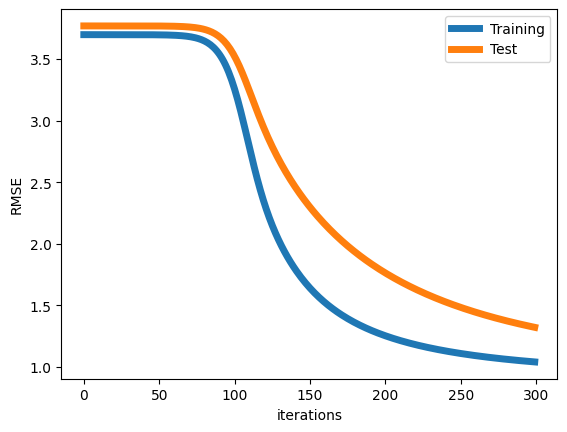

In [43]:
latent_factors = [40]
regularizations = [0.01]
iter_array = [300]
learning_rates = [0.0001]

best_params = {}
best_params["n_factors"] = latent_factors[0]
best_params["reg"] = regularizations[0]
best_params["n_iter"] = iter_array[0]
best_params["lr"] = learning_rates[0]
best_params["train_rmse"] = np.inf
best_params["test_rmse"] = np.inf
best_params["model"] = None


for fact, n_iter, reg, lr in itertools.product(
    latent_factors, iter_array, regularizations,learning_rates):
    print(f"Factors: {fact}")
    print(f"iterations: {n_iter}")
    print(f"regularization: {reg}"),
    print(f"learning_rate: {lr}")

    method = "gd"
    model_name = "".join([
        method,
        "_fact_", str(fact),
        "_reg_", str(reg),
        "_iter_", str(n_iter),
        "_lr_",str(lr),
    ])
    gd_grid = ExplicitMF(
        train=train,
        method=method,
        n_factors=fact,
        n_iterations=n_iter,
        reg=reg,
        learning_rate=lr,
    )
    start_time = time.time()
    gd_grid.training(test)
    training_time = time.time() - start_time
    min_idx = np.argmin(gd_grid.test_rmse)
    if gd_grid.test_rmse[min_idx] >= best_params["test_rmse"]:
        continue

    metrics = gd_grid.get_all_metrics(test)
    results.append(
        [model_name] + list(dataclasses.astuple(metrics)) + [training_time])
    best_params["n_factors"] = fact
    best_params["reg"] = reg
    best_params["n_iter"] = n_iter
    best_params["lr"] = lr
    best_params["train_rmse"] = gd_grid.train_rmse[min_idx]
    best_params["test_rmse"] = gd_grid.test_rmse[min_idx]
    best_params["model"] = gd_grid
    print("New optimal hyperparameters")
    print(pd.Series(best_params))
    print(f"--- {training_time} seconds ---")

best_gd_model = best_params["model"]
plot_learning_curve(best_gd_model)

results_pd = results_to_dataframe(results)
results_pd.style.background_gradient(
    "RdYlGn_r", axis=0, subset=lower_better,
).background_gradient("RdYlGn", axis=0, subset=higher_better)

Streaming output truncated to the last 5000 lines.
 [-0.2127768  -0.05203346  0.37453178 ... -0.03970326  0.12757919
  -0.25496053]
 [-0.39063373 -0.11155317  0.72803334 ... -0.06650226  0.27130799
  -0.49529612]
 [-0.3542527  -0.12729107  0.69356194 ... -0.02266946  0.21984666
  -0.45087661]]
Iteration 269, Train RMSE: 1.075273261197439, Test RMSE: 1.4044377400325567
	current iteration: 270
Iteration: 271
[[-0.38376962 -0.11873268  0.72226704 ... -0.03479396  0.23846581
  -0.45708073]
 [-0.34293804 -0.12329541  0.63560897 ... -0.06681238  0.21993276
  -0.40766121]
 [-0.2435463  -0.0716341   0.49155842 ... -0.06730411  0.17428769
  -0.3225395 ]
 ...
 [-0.21361321 -0.05231385  0.37609585 ... -0.0398486   0.12811105
  -0.25596552]
 [-0.39073143 -0.11159247  0.72821782 ... -0.06646934  0.27138518
  -0.49545644]
 [-0.3541949  -0.12725719  0.69349405 ... -0.02266863  0.21980255
  -0.45080582]]
Iteration 270, Train RMSE: 1.0738589247129067, Test RMSE: 1.4010858830056938
Iteration: 272
[[-0.3

,RMSE training,RMSE test,MRR k=5 test,MRR k=10 test,Mean NDCG k=5 test,Mean NDCG k=10 test,MAP k=5 test,MAP k=10 test,Training time
Model / Metric,,,,,,,,,
pop,3.136820,3.149080,0.270113,0.289745,0.116940,0.114835,0.256304,0.250318,1.757337
bias,2.954830,3.162426,0.262973,0.287045,0.119098,0.121382,0.251417,0.250013,5.789634
gd,1.269532,1.744437,0.162566,0.180684,0.076866,0.074409,0.161986,0.174005,142.396229
als,0.680239,2.654498,0.000954,0.001459,0.000751,0.000864,0.000954,0.001459,163.240121
gd_fact_10_reg_0.001_iter_20_lr_0.0001,3.698244,3.769107,0.014051,0.018806,0.006342,0.007698,0.014051,0.018825,140.757507
gd_fact_10_reg_0.001_iter_50_lr_0.0001,3.697446,3.768669,0.137946,0.151528,0.058631,0.057251,0.134123,0.139248,351.371239
gd_fact_40_reg_0.01_iter_50_lr_0.0001,3.696438,3.768189,0.142382,0.156021,0.061647,0.059658,0.138912,0.145341,356.812690
gd_fact_40_reg_0.01_iter_300_lr_0.0001,1.041666,1.322426,0.099806,0.117363,0.049021,0.051404,0.098088,0.111670,2156.995076
gd_fact_40_reg_0.01_iter_600_lr_0.0001,0.933696,1.035679,0.047879,0.071336,0.021667,0.034628,0.047596,0.068693,4196.668447


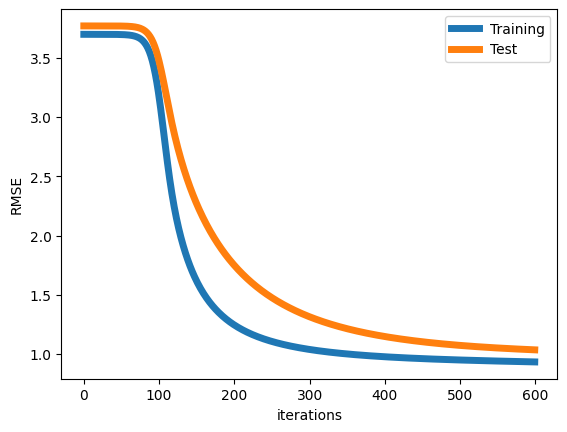

In [44]:
latent_factors = [40]
regularizations = [0.01]
iter_array = [600]
learning_rates = [0.0001]

best_params = {}
best_params["n_factors"] = latent_factors[0]
best_params["reg"] = regularizations[0]
best_params["n_iter"] = iter_array[0]
best_params["lr"] = learning_rates[0]
best_params["train_rmse"] = np.inf
best_params["test_rmse"] = np.inf
best_params["model"] = None


for fact, n_iter, reg, lr in itertools.product(
    latent_factors, iter_array, regularizations,learning_rates):
    print(f"Factors: {fact}")
    print(f"iterations: {n_iter}")
    print(f"regularization: {reg}"),
    print(f"learning_rate: {lr}")

    method = "gd"
    model_name = "".join([
        method,
        "_fact_", str(fact),
        "_reg_", str(reg),
        "_iter_", str(n_iter),
        "_lr_",str(lr),
    ])
    gd_grid = ExplicitMF(
        train=train,
        method=method,
        n_factors=fact,
        n_iterations=n_iter,
        reg=reg,
        learning_rate=lr,
    )
    start_time = time.time()
    gd_grid.training(test)
    training_time = time.time() - start_time
    min_idx = np.argmin(gd_grid.test_rmse)
    if gd_grid.test_rmse[min_idx] >= best_params["test_rmse"]:
        continue

    metrics = gd_grid.get_all_metrics(test)
    results.append(
        [model_name] + list(dataclasses.astuple(metrics)) + [training_time])
    best_params["n_factors"] = fact
    best_params["reg"] = reg
    best_params["n_iter"] = n_iter
    best_params["lr"] = lr
    best_params["train_rmse"] = gd_grid.train_rmse[min_idx]
    best_params["test_rmse"] = gd_grid.test_rmse[min_idx]
    best_params["model"] = gd_grid
    print("New optimal hyperparameters")
    print(pd.Series(best_params))
    print(f"--- {training_time} seconds ---")

best_gd_model = best_params["model"]
plot_learning_curve(best_gd_model)

results_pd = results_to_dataframe(results)
results_pd.style.background_gradient(
    "RdYlGn_r", axis=0, subset=lower_better,
).background_gradient("RdYlGn", axis=0, subset=higher_better)

---

Factors: 40
iterations: 50
regularization: 0.01
learning_rate: 0.001
	current iteration: 0
Iteration: 1
[[ 0.00774353 -0.00344185  0.02149052 ... -0.01869227 -0.01901554
   0.0024579 ]
 [ 0.02388445 -0.00913837 -0.02196987 ...  0.0075864  -0.02949981
  -0.01498074]
 [ 0.0112068   0.01280453  0.00743318 ... -0.00039529  0.00145233
   0.00191973]
 ...
 [-0.00857153 -0.00200444  0.00501516 ... -0.00677973  0.00205286
   0.00936989]
 [ 0.00948726  0.00997349  0.01969906 ...  0.01432919  0.00658427
   0.00655423]
 [ 0.01515951  0.01166103  0.00064322 ...  0.01118173  0.02188715
   0.00532376]]
Iteration 0, Train RMSE: 3.700065174395112, Test RMSE: 3.751736137164118
Iteration: 2
[[ 0.00661496 -0.00347995  0.02233077 ... -0.01914606 -0.01875302
   0.00254276]
 [ 0.02370069 -0.00887771 -0.02244824 ...  0.00753551 -0.0290848
  -0.01485445]
 [ 0.01148693  0.0125117   0.00745507 ... -0.00034367  0.001699
   0.00213384]
 ...
 [-0.0085471  -0.00191079  0.00502369 ... -0.00693165  0.0020209
   0.009

,RMSE training,RMSE test,MRR k=5 test,MRR k=10 test,Mean NDCG k=5 test,Mean NDCG k=10 test,MAP k=5 test,MAP k=10 test,Training time
Model / Metric,,,,,,,,,
pop,3.137295,3.136782,0.266596,0.294282,0.115367,0.118949,0.249620,0.256037,1.573175
bias,2.956033,3.147252,0.266472,0.298066,0.121187,0.126634,0.252717,0.264195,3.434559
gd,1.264334,1.706291,0.157953,0.172651,0.075878,0.070110,0.156584,0.170276,138.207864
als,0.675149,2.931605,0.001096,0.001736,0.000727,0.001031,0.001096,0.001736,156.921379
gd_fact_40_reg_0.01_iter_50_lr_0.001,0.951679,1.042184,0.056062,0.072945,0.026194,0.032144,0.055815,0.071909,344.931896


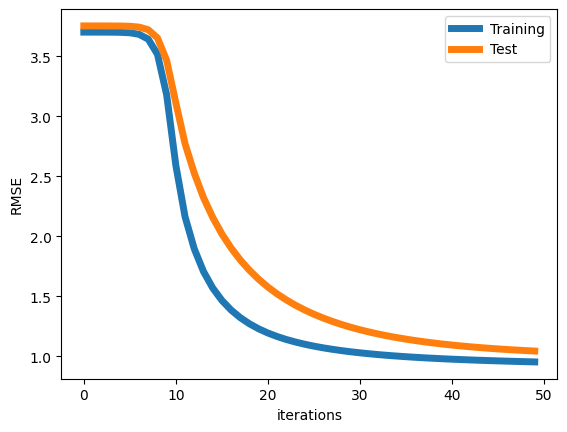

In [18]:
latent_factors = [40]
regularizations = [0.01]
iter_array = [50]
learning_rates = [0.001]

best_params = {}
best_params["n_factors"] = latent_factors[0]
best_params["reg"] = regularizations[0]
best_params["n_iter"] = iter_array[0]
best_params["lr"] = learning_rates[0]
best_params["train_rmse"] = np.inf
best_params["test_rmse"] = np.inf
best_params["model"] = None


for fact, n_iter, reg, lr in itertools.product(
    latent_factors, iter_array, regularizations,learning_rates):
    print(f"Factors: {fact}")
    print(f"iterations: {n_iter}")
    print(f"regularization: {reg}"),
    print(f"learning_rate: {lr}")

    method = "gd"
    model_name = "".join([
        method,
        "_fact_", str(fact),
        "_reg_", str(reg),
        "_iter_", str(n_iter),
        "_lr_",str(lr),
    ])
    gd_grid = ExplicitMF(
        train=train,
        method=method,
        n_factors=fact,
        n_iterations=n_iter,
        reg=reg,
        learning_rate=lr,
    )
    start_time = time.time()
    gd_grid.training(test)
    training_time = time.time() - start_time
    min_idx = np.argmin(gd_grid.test_rmse)
    if gd_grid.test_rmse[min_idx] >= best_params["test_rmse"]:
        continue

    metrics = gd_grid.get_all_metrics(test)
    results.append(
        [model_name] + list(dataclasses.astuple(metrics)) + [training_time])
    best_params["n_factors"] = fact
    best_params["reg"] = reg
    best_params["n_iter"] = n_iter
    best_params["lr"] = lr
    best_params["train_rmse"] = gd_grid.train_rmse[min_idx]
    best_params["test_rmse"] = gd_grid.test_rmse[min_idx]
    best_params["model"] = gd_grid
    print("New optimal hyperparameters")
    print(pd.Series(best_params))
    print(f"--- {training_time} seconds ---")

best_gd_model = best_params["model"]
plot_learning_curve(best_gd_model)

results_pd = results_to_dataframe(results)
results_pd.style.background_gradient(
    "RdYlGn_r", axis=0, subset=lower_better,
).background_gradient("RdYlGn", axis=0, subset=higher_better)

Factors: 40
iterations: 95
regularization: 0.01
learning_rate: 0.001
	current iteration: 0
Iteration: 1
[[ 0.00888751 -0.00171353 -0.00637442 ... -0.01549332 -0.0017385
  -0.00695727]
 [ 0.00443543  0.01242584 -0.01595016 ... -0.00152275  0.00425237
  -0.00814267]
 [ 0.00329949 -0.01998586  0.013698   ... -0.0050375   0.01607167
   0.01167038]
 ...
 [ 0.00858271 -0.00538369  0.0135129  ...  0.00021351 -0.02182183
   0.01059406]
 [ 0.00589997  0.00121666 -0.01245263 ...  0.01168898 -0.01024331
   0.00466048]
 [ 0.00061909  0.00934109 -0.00743837 ...  0.00276234 -0.00388685
   0.00347598]]
Iteration 0, Train RMSE: 3.7000762355272796, Test RMSE: 3.7517490029470784
Iteration: 2
[[ 0.00778935 -0.00069926 -0.00635122 ... -0.0154518  -0.00224932
  -0.00730969]
 [ 0.00418948  0.01291293 -0.0160016  ... -0.00154969  0.00423352
  -0.00791149]
 [ 0.00325272 -0.02015283  0.01335383 ... -0.00488459  0.01616977
   0.01171132]
 ...
 [ 0.0085779  -0.00522403  0.01338734 ...  0.00011726 -0.02195019
   

,RMSE training,RMSE test,MRR k=5 test,MRR k=10 test,Mean NDCG k=5 test,Mean NDCG k=10 test,MAP k=5 test,MAP k=10 test,Training time
Model / Metric,,,,,,,,,
pop,3.137295,3.136782,0.266596,0.294282,0.115367,0.118949,0.249620,0.256037,1.573175
bias,2.956033,3.147252,0.266472,0.298066,0.121187,0.126634,0.252717,0.264195,3.434559
gd,1.264334,1.706291,0.157953,0.172651,0.075878,0.070110,0.156584,0.170276,138.207864
als,0.675149,2.931605,0.001096,0.001736,0.000727,0.001031,0.001096,0.001736,156.921379
gd_fact_40_reg_0.01_iter_50_lr_0.001,0.951679,1.042184,0.056062,0.072945,0.026194,0.032144,0.055815,0.071909,344.931896
gd_fact_40_reg_0.01_iter_95_lr_0.001,0.994416,0.993237,0.096607,0.115328,0.043808,0.047125,0.093982,0.107475,661.776915


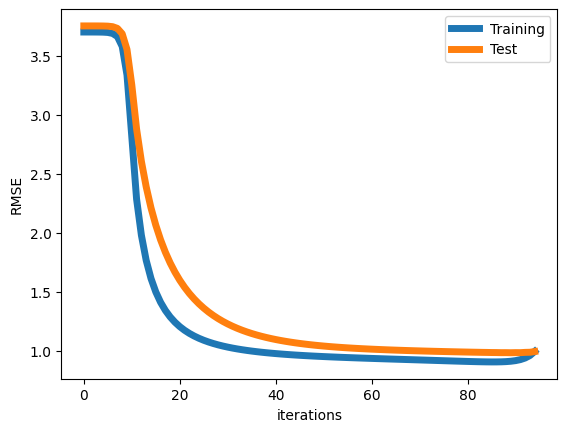

In [20]:
latent_factors = [40]
regularizations = [0.01]
iter_array = [95]
learning_rates = [0.001]

best_params = {}
best_params["n_factors"] = latent_factors[0]
best_params["reg"] = regularizations[0]
best_params["n_iter"] = iter_array[0]
best_params["lr"] = learning_rates[0]
best_params["train_rmse"] = np.inf
best_params["test_rmse"] = np.inf
best_params["model"] = None


for fact, n_iter, reg, lr in itertools.product(
    latent_factors, iter_array, regularizations,learning_rates):
    print(f"Factors: {fact}")
    print(f"iterations: {n_iter}")
    print(f"regularization: {reg}"),
    print(f"learning_rate: {lr}")

    method = "gd"
    model_name = "".join([
        method,
        "_fact_", str(fact),
        "_reg_", str(reg),
        "_iter_", str(n_iter),
        "_lr_",str(lr),
    ])
    gd_grid = ExplicitMF(
        train=train,
        method=method,
        n_factors=fact,
        n_iterations=n_iter,
        reg=reg,
        learning_rate=lr,
    )
    start_time = time.time()
    gd_grid.training(test)
    training_time = time.time() - start_time
    min_idx = np.argmin(gd_grid.test_rmse)
    if gd_grid.test_rmse[min_idx] >= best_params["test_rmse"]:
        continue

    metrics = gd_grid.get_all_metrics(test)
    results.append(
        [model_name] + list(dataclasses.astuple(metrics)) + [training_time])
    best_params["n_factors"] = fact
    best_params["reg"] = reg
    best_params["n_iter"] = n_iter
    best_params["lr"] = lr
    best_params["train_rmse"] = gd_grid.train_rmse[min_idx]
    best_params["test_rmse"] = gd_grid.test_rmse[min_idx]
    best_params["model"] = gd_grid
    print("New optimal hyperparameters")
    print(pd.Series(best_params))
    print(f"--- {training_time} seconds ---")

best_gd_model = best_params["model"]
plot_learning_curve(best_gd_model)

results_pd = results_to_dataframe(results)
results_pd.style.background_gradient(
    "RdYlGn_r", axis=0, subset=lower_better,
).background_gradient("RdYlGn", axis=0, subset=higher_better)

Factors: 1
iterations: 20
regularization: 0.01
learning_rate: 0.001
	current iteration: 0
Iteration 0, Train RMSE: 3.6990743619082345, Test RMSE: 3.7614437374939933
Iteration 1, Train RMSE: 3.6990736727820686, Test RMSE: 3.7614437972349353
Iteration 2, Train RMSE: 3.6990727810057944, Test RMSE: 3.7614437214612564
Iteration 3, Train RMSE: 3.6990713564892763, Test RMSE: 3.761443283454499
Iteration 4, Train RMSE: 3.6990683845396584, Test RMSE: 3.7614418243089482
Iteration 5, Train RMSE: 3.6990606148673426, Test RMSE: 3.7614373313697405
Iteration 6, Train RMSE: 3.6990374767054566, Test RMSE: 3.7614234883323014
Iteration 7, Train RMSE: 3.698964380888093, Test RMSE: 3.7613801392487316
Iteration 8, Train RMSE: 3.698727871067957, Test RMSE: 3.7612422849903826
Iteration 9, Train RMSE: 3.6979555496025296, Test RMSE: 3.760798970468854
	current iteration: 10
Iteration 10, Train RMSE: 3.6954261816726492, Test RMSE: 3.7593634536650233
Iteration 11, Train RMSE: 3.6871517458741416, Test RMSE: 3.754703

,RMSE training,RMSE test,MRR k=5 test,MRR k=10 test,Mean NDCG k=5 test,Mean NDCG k=10 test,MAP k=5 test,MAP k=10 test,Training time
Model / Metric,,,,,,,,,
pop,3.138574,3.136055,0.281478,0.302888,0.124897,0.119151,0.268328,0.270817,1.618129
bias,2.957059,3.147899,0.277996,0.300613,0.128575,0.125571,0.266483,0.272238,5.319382
gd,1.283991,1.738351,0.150230,0.166258,0.073218,0.069923,0.150866,0.159828,136.767977
als,0.679043,2.019119,0.001838,0.001838,0.000835,0.000696,0.001838,0.001838,158.612919
gd_fact_1_reg_0.01_iter_20_lr_0.001,1.613058,2.210224,0.188636,0.214034,0.090607,0.093275,0.183619,0.200315,136.159481
gd_fact_15_reg_0.01_iter_20_lr_0.001,1.273544,1.721558,0.148462,0.165504,0.071944,0.069413,0.149160,0.159855,136.535233
gd_fact_40_reg_0.01_iter_20_lr_0.001,1.236413,1.654866,0.125946,0.145410,0.061827,0.062820,0.124605,0.141447,139.398411
gd_fact_90_reg_0.01_iter_20_lr_0.001,1.211327,1.609120,0.123719,0.143905,0.060662,0.062722,0.121380,0.137027,154.644522


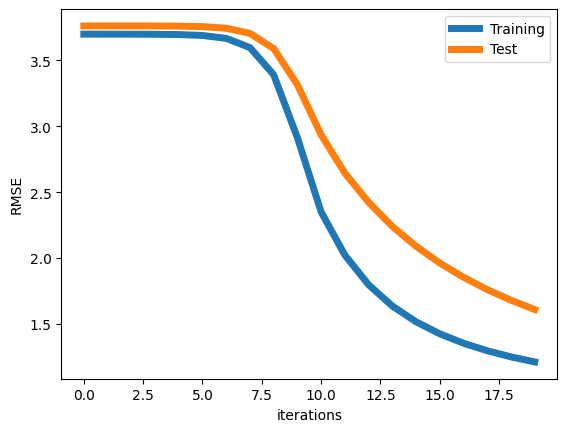

In [20]:
latent_factors = [1 ,15,40,90]
regularizations = [0.01]
iter_array = [20]
learning_rates = [0.001]

best_params = {}
best_params["n_factors"] = latent_factors[0]
best_params["reg"] = regularizations[0]
best_params["n_iter"] = iter_array[0]
best_params["lr"] = learning_rates[0]
best_params["train_rmse"] = np.inf
best_params["test_rmse"] = np.inf
best_params["model"] = None


for fact, n_iter, reg, lr in itertools.product(
    latent_factors, iter_array, regularizations,learning_rates):
    print(f"Factors: {fact}")
    print(f"iterations: {n_iter}")
    print(f"regularization: {reg}"),
    print(f"learning_rate: {lr}")

    method = "gd"
    model_name = "".join([
        method,
        "_fact_", str(fact),
        "_reg_", str(reg),
        "_iter_", str(n_iter),
        "_lr_",str(lr),
    ])
    gd_grid = ExplicitMF(
        train=train,
        method=method,
        n_factors=fact,
        n_iterations=n_iter,
        reg=reg,
        learning_rate=lr,
    )
    start_time = time.time()
    gd_grid.training(test)
    training_time = time.time() - start_time
    min_idx = np.argmin(gd_grid.test_rmse)
    if gd_grid.test_rmse[min_idx] >= best_params["test_rmse"]:
        continue

    metrics = gd_grid.get_all_metrics(test)
    results.append(
        [model_name] + list(dataclasses.astuple(metrics)) + [training_time])
    best_params["n_factors"] = fact
    best_params["reg"] = reg
    best_params["n_iter"] = n_iter
    best_params["lr"] = lr
    best_params["train_rmse"] = gd_grid.train_rmse[min_idx]
    best_params["test_rmse"] = gd_grid.test_rmse[min_idx]
    best_params["model"] = gd_grid
    print("New optimal hyperparameters")
    print(pd.Series(best_params))
    print(f"--- {training_time} seconds ---")

best_gd_model = best_params["model"]
plot_learning_curve(best_gd_model)

results_pd = results_to_dataframe(results)
results_pd.style.background_gradient(
    "RdYlGn_r", axis=0, subset=lower_better,
).background_gradient("RdYlGn", axis=0, subset=higher_better)

Factors: 15
iterations: 20
regularization: 0.01
learning_rate: 0.001
	current iteration: 0
Iteration 0, Train RMSE: 3.6994649053638873, Test RMSE: 3.7576478021778006
Iteration 1, Train RMSE: 3.69944794379992, Test RMSE: 3.757644653013964
Iteration 2, Train RMSE: 3.699411416522374, Test RMSE: 3.7576307932335897
Iteration 3, Train RMSE: 3.699310882929932, Test RMSE: 3.7575818992578656
Iteration 4, Train RMSE: 3.699001183166596, Test RMSE: 3.757418514811827
Iteration 5, Train RMSE: 3.6980059370058025, Test RMSE: 3.7568800198542207
Iteration 6, Train RMSE: 3.6947624864003332, Test RMSE: 3.755111871185008
Iteration 7, Train RMSE: 3.684171641968866, Test RMSE: 3.7493258760831094
Iteration 8, Train RMSE: 3.649900035816907, Test RMSE: 3.7305855954621325
Iteration 9, Train RMSE: 3.54282807784192, Test RMSE: 3.6719270516367297
	current iteration: 10
Iteration 10, Train RMSE: 3.2453238755252842, Test RMSE: 3.5074559017551237
Iteration 11, Train RMSE: 2.6756826955338995, Test RMSE: 3.1740351602735

,RMSE training,RMSE test,MRR k=5 test,MRR k=10 test,Mean NDCG k=5 test,Mean NDCG k=10 test,MAP k=5 test,MAP k=10 test,Training time
Model / Metric,,,,,,,,,
pop,3.136703,3.143320,0.274744,0.297819,0.120209,0.116486,0.263559,0.263305,6.245615
bias,2.955119,3.155073,0.271598,0.296235,0.122910,0.120703,0.260893,0.263233,5.193433
gd,1.321552,1.824572,0.179180,0.194790,0.084605,0.078647,0.173957,0.184915,140.897341
als,0.677761,1.658778,0.001273,0.001910,0.000451,0.000633,0.001273,0.001910,158.665256
gd_fact_10_reg_0.001_iter_20_lr_0.001,1.295364,1.779740,0.173206,0.189402,0.082251,0.077076,0.169335,0.180553,138.828318
gd_fact_15_reg_0.01_iter_20_lr_0.001,1.276031,1.747527,0.162831,0.183864,0.074189,0.074356,0.158952,0.174218,140.121462
gd_fact_15_reg_0.1_iter_20_lr_0.001,1.275988,1.747356,0.163415,0.184355,0.074695,0.075022,0.159170,0.174683,140.146904


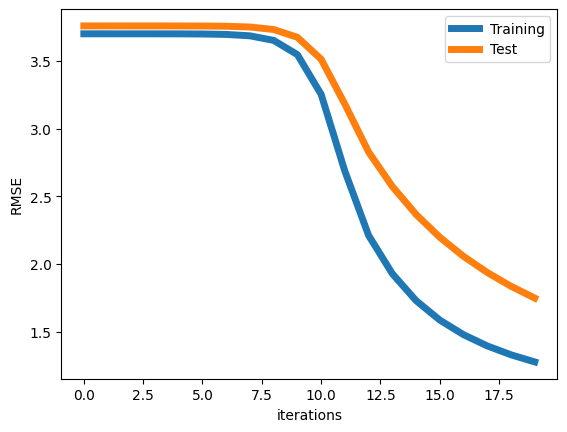

In [19]:
latent_factors = [15]
regularizations = [0.01,0.1,0.001]
iter_array = [20]
learning_rates = [0.001]

best_params = {}
best_params["n_factors"] = latent_factors[0]
best_params["reg"] = regularizations[0]
best_params["n_iter"] = iter_array[0]
best_params["lr"] = learning_rates[0]
best_params["train_rmse"] = np.inf
best_params["test_rmse"] = np.inf
best_params["model"] = None


for fact, n_iter, reg, lr in itertools.product(
    latent_factors, iter_array, regularizations,learning_rates):
    print(f"Factors: {fact}")
    print(f"iterations: {n_iter}")
    print(f"regularization: {reg}"),
    print(f"learning_rate: {lr}")

    method = "gd"
    model_name = "".join([
        method,
        "_fact_", str(fact),
        "_reg_", str(reg),
        "_iter_", str(n_iter),
        "_lr_",str(lr),
    ])
    gd_grid = ExplicitMF(
        train=train,
        method=method,
        n_factors=fact,
        n_iterations=n_iter,
        reg=reg,
        learning_rate=lr,
    )
    start_time = time.time()
    gd_grid.training(test)
    training_time = time.time() - start_time
    min_idx = np.argmin(gd_grid.test_rmse)
    if gd_grid.test_rmse[min_idx] >= best_params["test_rmse"]:
        continue

    metrics = gd_grid.get_all_metrics(test)
    results.append(
        [model_name] + list(dataclasses.astuple(metrics)) + [training_time])
    best_params["n_factors"] = fact
    best_params["reg"] = reg
    best_params["n_iter"] = n_iter
    best_params["lr"] = lr
    best_params["train_rmse"] = gd_grid.train_rmse[min_idx]
    best_params["test_rmse"] = gd_grid.test_rmse[min_idx]
    best_params["model"] = gd_grid
    print("New optimal hyperparameters")
    print(pd.Series(best_params))
    print(f"--- {training_time} seconds ---")

best_gd_model = best_params["model"]
plot_learning_curve(best_gd_model)

results_pd = results_to_dataframe(results)
results_pd.style.background_gradient(
    "RdYlGn_r", axis=0, subset=lower_better,
).background_gradient("RdYlGn", axis=0, subset=higher_better)

#### Question 4 (5 points)

Which are the best hyperparameters for the GD model?

Discuss your observations (overfitting, etc.)


``` Your response here ```
1. **Learning Rate**:
* Controls the step size during optimization.
* Small values - Slow convergence, risk of getting stuck in local minima.
* Large values - May overshoot the minimum or fail to converge.
2. **Regularization Parameter**:
* Prevents overfitting by penalizing large weights.
* Small values - Higher risk of overfitting (model focuses too much on training data).
* Large values - Higher risk of underfitting (model fails to capture patterns in data).
3. **Number of Factors**:
* Number of latent features in the factorization.
* Small values - Can lead to underfitting (insufficient representation of the data).
* Large values - Can lead to overfitting (too much complexity in the model).
4. **Number of Iterations**:
* Number of passes over the entire.
* Small values - Can lead to underfitting (insufficient training).
* Large values - Can lead to overfitting (model memorizes noise in data).


**Best Model**:<br>
Model - gd_fact_40_reg_0.01_iter_50_lr_0.001, Train RMSE: 0.951679, Test RMSE: 1.042184. This configuration balances train and test RMSE, indicating a good generalization capability. Simple configuration performs better
.

---

####Question 5 (5 points)

Compare all models trained (popularity, bias, ALS, GD); Are different models better when considering different metrics? Discuss the reasoning. Discuss your insights regarding the models performance (accuracy, time to train etc.). Describe possible tasks and their corresponding preferable model.

``` Your response here ```

In [22]:
import pandas as pd

data = {
    'Model': ['Popularity', 'Bias', 'ALS', 'GD'],
    'RMSE (test)': ['High', 'Moderate', 'Low', 'Low'],
    'MRR (test)': ['Low', 'Low', 'High', 'High'],
    'NDCG (test)': ['Low', 'Low', 'High', 'High'],
    'MAP (test)': ['Low', 'Low', 'High', 'High'],
    'Training Time': ['Very Low', 'Low', 'Moderate', 'High']
}

df = pd.DataFrame(data)
df

,Model,RMSE (test),MRR (test),NDCG (test),MAP (test),Training Time
0,Popularity,High,Low,Low,Low,Very Low
1,Bias,Moderate,Low,Low,Low,Low
2,ALS,Low,High,High,High,Moderate
3,GD,Low,High,High,High,High


* **Popularity**:The popularity model solely relies on item popularity, ignoring user preferences. This explains its poor performance, which consider user-specific recommendations. However, its training time is exceptionally low.

* **Bias**: The bias model incorporates user and item biases, leading to some improvement over the popularity model. Nevertheless, it still performs poorly on personalized metrics compared to ALS and GD. It also trains quickly.

* **ALS and GD**: Both ALS and GD models factorize the user-item interaction matrix to learn latent representations for users and items. This allows them to capture personalized preferences effectively, leading to superior performance. However, ALS has a lower training time compared to GD.

**Insights into model performance**
* **Accuracy**:ALS and GD offer the highest accuracy, as indicated by their low RMSE and high scores on ranking metrics. Bias provides moderate accuracy, while popularity is the least accurate.

* **Training Time**:Popularity and bias models are the fastest to train. ALS offers a good balance between accuracy and training time, while GD is the slowest but potentially more accurate with proper hyperparameter tuning.

**Possible tasks and preferable models**
* **Basic recommendations (top-N lists)**: Popularity or bias models can be sufficient for quickly providing general recommendations.

* **Personalized recommendations (product suggestions)**: ALS or GD models are preferred for tasks requiring accurate and user-specific recommendations.

* **Cold-start scenarios (new users or items)**: Content-based or hybrid approaches might be more suitable for cases with limited user-item interactions.

* **Real-time recommendations**: Popularity or bias models might be favored due to their fast prediction times. ALS can also be used.

Overall, the choice of the best model depends on the specific task requirements and constraints. ALS and GD offer the best accuracy but require more training time, while popularity and bias models are faster but less accurate.


---

####Question 6 (5 points bonus)

Suggest possible enhancements that could potentially improve your models (no need to implement).

``` Your response here ```

**Incorporating User and Item Features**

* **User demographics (age, gender, occupation)**: Including user demographic information could help capture user preferences more effectively.

* **Item metadata (genre, release date, actors)**: Adding item metadata could enhance recommendations based on content similarity.

**Advanced Matrix Factorization Techniques**

* **SVD++**: This technique considers implicit feedback to improve prediction accuracy.

* **Non-negative Matrix Factorization (NMF)**:  NMF enforces non-negativity constraints on the latent factors, which can lead to more interpretable and potentially more accurate results.

**Addressing Cold-Start Problem**

* **Content-based filtering**: For new users or items with limited interactions, content-based filtering can be used to provide recommendations based on similarity to existing items.

* **Hybrid approaches**: Combining collaborative filtering with content-based or other approaches can improve recommendations in cold-start scenarios.

**Context-Aware Recommendations**

* **Time of day, location, device**: Taking into account contextual factors can personalize recommendations further.

* **Session-based recommendations**: Analyzing user behavior within a session can provide relevant suggestions.

**Deep Learning-Based Models**

* **Neural Collaborative Filtering**: Using deep neural networks can capture complex interactions between users and items.

* **Autoencoders**: Autoencoders can learn compressed representations of user-item interactions and provide recommendations based on these representations.

**Other Enhancements**:

* **Ensemble methods**: Combining predictions from multiple models can improve overall accuracy.

* **Model-based hyperparameter optimization**: Using automated techniques like Bayesian optimization can find optimal hyperparameters more efficiently.

* **Evaluating diverse metrics**: Beyond RMSE, focusing on ranking metrics like MRR, NDCG, and MAP can provide a more comprehensive view of model performance.

* **Explainable recommendations**: Providing explanations for why a specific item is recommended can enhance user trust and satisfaction.

---

## Model explainability
In this section, you will try to qualitatively asses the results of your models



#### Question 7 (5 points)

Select an item similarity method which you find best suitable for this dataset and implement it using numpy and pandas only.

Factors: 2
iterations: 10
regularization: 0.2
	current iteration: 0
Iteration 0, Train RMSE: 2.3553993998189053, Test RMSE: 3.0622854001618913
Iteration 1, Train RMSE: 0.9200316615653524, Test RMSE: 1.0505691274556097
Iteration 2, Train RMSE: 0.8915182066738282, Test RMSE: 1.0067343241377693
Iteration 3, Train RMSE: 0.8858770758344807, Test RMSE: 1.0107371910548157
Iteration 4, Train RMSE: 0.8830029557193305, Test RMSE: 1.0113524008804666
Iteration 5, Train RMSE: 0.8810729393276737, Test RMSE: 1.0107488569239702
Iteration 6, Train RMSE: 0.8796996600969682, Test RMSE: 1.0104044270139583
Iteration 7, Train RMSE: 0.8786248663216559, Test RMSE: 1.0100258837602045
Iteration 8, Train RMSE: 0.8776082820032386, Test RMSE: 1.0098619039063803
Iteration 9, Train RMSE: 0.8766132489613364, Test RMSE: 1.0086979207112317
New optimal hyperparameters
n_factors                                                  2
reg                                                      0.2
n_iter                          

,RMSE training,RMSE test,MRR k=5 test,MRR k=10 test,Mean NDCG k=5 test,Mean NDCG k=10 test,MAP k=5 test,MAP k=10 test,Training time
Model / Metric,,,,,,,,,
pop,3.135577,3.154388,0.254136,0.279259,0.111640,0.112609,0.244950,0.250991,5.421992
bias,2.954042,3.165551,0.251962,0.278270,0.116115,0.116542,0.242571,0.251680,4.550447
gd,1.270908,1.743852,0.159385,0.175621,0.077610,0.072700,0.158213,0.170913,145.189017
als,0.677808,2.238116,0.000566,0.001158,0.000331,0.000611,0.000566,0.001158,158.407466
als_fact_2_reg_0.2_iter_10,0.876613,1.008698,0.001060,0.001212,0.000325,0.000330,0.001060,0.001212,95.327587


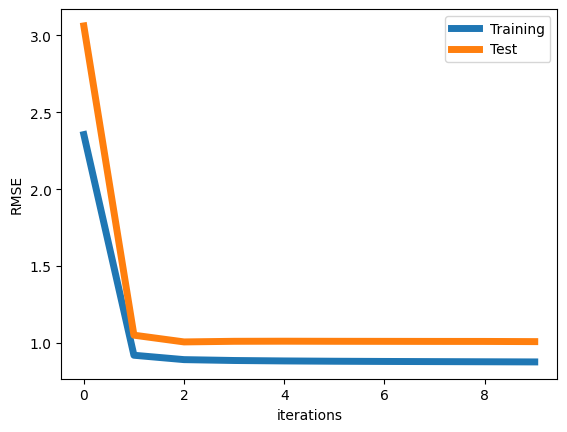

In [17]:
#  best als_fact_1_reg_0.2_iter_10
latent_factors = [2]
regularizations = [0.2]
iter_array = [10]

best_params = {}
best_params["n_factors"] = latent_factors[0]
best_params["reg"] = regularizations[0]
best_params["n_iter"] = iter_array[0]
best_params["train_rmse"] = np.inf
best_params["test_rmse"] = np.inf
best_params["model"] = None


for fact, n_iter, reg in itertools.product(
    latent_factors, iter_array, regularizations):
    print(f"Factors: {fact}")
    print(f"iterations: {n_iter}")
    print(f"regularization: {reg}")

    method = "als"
    model_name = "".join([
        method,
        "_fact_", str(fact),
        "_reg_", str(reg),
        "_iter_", str(n_iter)
    ])
    als_grid = ExplicitMF(
        train=train,
        method=method,
        n_factors=fact,
        n_iterations=n_iter,
        reg=reg,
    )
    start_time = time.time()
    als_grid.training(test)
    training_time = time.time() - start_time
    min_idx = np.argmin(als_grid.test_rmse)
    if als_grid.test_rmse[min_idx] >= best_params["test_rmse"]:
        continue

    metrics = als_grid.get_all_metrics(test)
    results.append(
        [model_name] + list(dataclasses.astuple(metrics)) + [training_time])
    best_params["n_factors"] = fact
    best_params["reg"] = reg
    best_params["n_iter"] = n_iter
    best_params["train_rmse"] = als_grid.train_rmse[min_idx]
    best_params["test_rmse"] = als_grid.test_rmse[min_idx]
    best_params["model"] = als_grid
    print("New optimal hyperparameters")
    print(pd.Series(best_params))
    print(f"--- {training_time} seconds ---")

best_als_model = best_params["model"]
plot_learning_curve(best_als_model)

results_pd = results_to_dataframe(results)
results_pd.style.background_gradient(
    "RdYlGn_r", axis=0, subset=lower_better,
).background_gradient("RdYlGn", axis=0, subset=higher_better)

Factors: 40
iterations: 50
regularization: 0.01
learning_rate: 0.001
	current iteration: 0
Iteration 0, Train RMSE: 3.6986232866823463, Test RMSE: 3.7653941498652097
Iteration 1, Train RMSE: 3.698575304051661, Test RMSE: 3.7653834714320977
Iteration 2, Train RMSE: 3.698466407535199, Test RMSE: 3.7653390359146615
Iteration 3, Train RMSE: 3.6981583803984073, Test RMSE: 3.765185248699011
Iteration 4, Train RMSE: 3.6971992471741753, Test RMSE: 3.7646754943255996
Iteration 5, Train RMSE: 3.6941074544871637, Test RMSE: 3.763002340225297
Iteration 6, Train RMSE: 3.6840472286632133, Test RMSE: 3.7575311897283625
Iteration 7, Train RMSE: 3.651505216116754, Test RMSE: 3.7398035727463284
Iteration 8, Train RMSE: 3.5495859195199095, Test RMSE: 3.6841461264628896
Iteration 9, Train RMSE: 3.263836946000657, Test RMSE: 3.526494310998963
	current iteration: 10
Iteration 10, Train RMSE: 2.7017877810014386, Test RMSE: 3.197737811913551
Iteration 11, Train RMSE: 2.220087642223581, Test RMSE: 2.8368705426

,RMSE training,RMSE test,MRR k=5 test,MRR k=10 test,Mean NDCG k=5 test,Mean NDCG k=10 test,MAP k=5 test,MAP k=10 test,Training time
Model / Metric,,,,,,,,,
pop,3.135577,3.154388,0.254136,0.279259,0.111640,0.112609,0.244950,0.250991,5.421992
bias,2.954042,3.165551,0.251962,0.278270,0.116115,0.116542,0.242571,0.251680,4.550447
gd,1.270908,1.743852,0.159385,0.175621,0.077610,0.072700,0.158213,0.170913,145.189017
als,0.677808,2.238116,0.000566,0.001158,0.000331,0.000611,0.000566,0.001158,158.407466
als_fact_2_reg_0.2_iter_10,0.876613,1.008698,0.001060,0.001212,0.000325,0.000330,0.001060,0.001212,95.327587
gd_fact_40_reg_0.01_iter_50_lr_0.001,0.950724,1.060920,0.054083,0.071887,0.026946,0.033365,0.053570,0.071088,354.706742


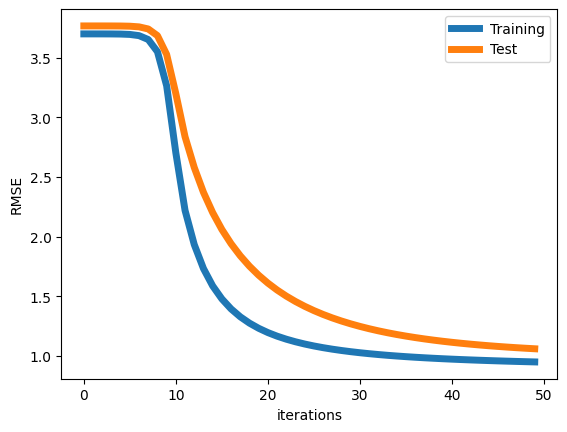

In [18]:
# gd_fact_40_reg_0.01_iter_50_lr_0.001
latent_factors = [40]
regularizations = [0.01]
iter_array = [50]
learning_rates = [0.001]

best_params = {}
best_params["n_factors"] = latent_factors[0]
best_params["reg"] = regularizations[0]
best_params["n_iter"] = iter_array[0]
best_params["lr"] = learning_rates[0]
best_params["train_rmse"] = np.inf
best_params["test_rmse"] = np.inf
best_params["model"] = None


for fact, n_iter, reg, lr in itertools.product(
    latent_factors, iter_array, regularizations,learning_rates):
    print(f"Factors: {fact}")
    print(f"iterations: {n_iter}")
    print(f"regularization: {reg}"),
    print(f"learning_rate: {lr}")

    method = "gd"
    model_name = "".join([
        method,
        "_fact_", str(fact),
        "_reg_", str(reg),
        "_iter_", str(n_iter),
        "_lr_",str(lr),
    ])
    gd_grid = ExplicitMF(
        train=train,
        method=method,
        n_factors=fact,
        n_iterations=n_iter,
        reg=reg,
        learning_rate=lr,
    )
    start_time = time.time()
    gd_grid.training(test)
    training_time = time.time() - start_time
    min_idx = np.argmin(gd_grid.test_rmse)
    if gd_grid.test_rmse[min_idx] >= best_params["test_rmse"]:
        continue

    metrics = gd_grid.get_all_metrics(test)
    results.append(
        [model_name] + list(dataclasses.astuple(metrics)) + [training_time])
    best_params["n_factors"] = fact
    best_params["reg"] = reg
    best_params["n_iter"] = n_iter
    best_params["lr"] = lr
    best_params["train_rmse"] = gd_grid.train_rmse[min_idx]
    best_params["test_rmse"] = gd_grid.test_rmse[min_idx]
    best_params["model"] = gd_grid
    print("New optimal hyperparameters")
    print(pd.Series(best_params))
    print(f"--- {training_time} seconds ---")

best_gd_model = best_params["model"]
plot_learning_curve(best_gd_model)

results_pd = results_to_dataframe(results)
results_pd.style.background_gradient(
    "RdYlGn_r", axis=0, subset=lower_better,
).background_gradient("RdYlGn", axis=0, subset=higher_better)

In [30]:
def similarity(model: ExplicitMF) -> np.ndarray:
    """Computes item-to-item similarity.

    Args:
        model: trained RS model.

    Returns:
        Similarity matrix.
    """
    # Your code here
    V = model.model_params.get("V")
    if V is None:  # Handle popularity and bias models
        predictions = model.predict_all()
        V = predictions.T  # Use item predictions as features

    n_items = V.shape[0]
    similarity_matrix = np.zeros((n_items, n_items))

    for i in range(n_items):
        for j in range(i + 1, n_items):
            # Calculate cosine similarity with handling for zero norms
            denominator = np.linalg.norm(V[i]) * np.linalg.norm(V[j])
            if denominator == 0:
                similarity_matrix[i, j] = 0  # Set similarity to 0 if denominator is 0
            else:
                similarity_matrix[i, j] = np.dot(V[i], V[j]) / denominator
            similarity_matrix[j, i] = similarity_matrix[i, j]  # Ensure symmetry

    return similarity_matrix



pop_sim = similarity(pop)
bias_sim = similarity(bias)
als_sim = similarity(best_als_model)
gd_sim = similarity(best_gd_model)

In [31]:
def display_top_k_movies(similarity: np.ndarray, movie_idx: int, k: int = 5):
    """Prints most similar movies.

    Args:
        similarity: similarity matrix.
        movie_idx: movie index.
        k: number of similar movies to print.
    """
    movie_indices = np.argsort(similarity[movie_idx, :])[::-1]
    movie_titles = []
    # Start i at 1 to not grab the input movie.
    i = 1
    while i <= k:
        movie_titles.append(df_items['movie_title'][movie_indices[i]])
        i += 1
    print("Recommended movies: ", movie_titles)


def compare_recs(pop_similarity: np.ndarray, bias_similarity: np.ndarray,
                 als_similarity: np.ndarray, gd_similarity: np.ndarray,
                 movie_idx: int, k: int = 5):
    """Prints most similar movies in every model.

    Args:
        pop_similarity: similarity matrix for popularity model.
        bias_similarity: similarity matrix for bias model.
        als_similarity: similarity matrix for als model.
        gd_similarity: similarity matrix for gd model.
        movie_idx: movie index.
        k: number of similar movies to print.
    """
    print("Input movie: ", df_items['movie_title'][movie_idx])

    print("Popularity model recommendations:")
    display_top_k_movies(pop_similarity, movie_idx, k)

    print("Bias model recommendations:")
    display_top_k_movies(bias_similarity, movie_idx, k)

    print("GD model recommendations:")
    display_top_k_movies(gd_similarity, movie_idx, k)

    print("ALS model recommendations:")
    display_top_k_movies(als_similarity, movie_idx, k)


---

####Question 8 (5 points)

Compare between the recommendations of the various models.

Show the recommendations for three movies and discuss the quality of the results obtained by the different models.

``` Your response here ```

In [34]:
movie_idx =  2
k = 5
compare_recs(pop_sim, bias_sim, als_sim, gd_sim, movie_idx, k)

Input movie:  Four Rooms (1995)
Popularity model recommendations:
Recommended movies:  ['Clerks (1994)', 'Hamlet (1996)', 'Kansas City (1996)', 'Super Mario Bros. (1993)', 'Shadow Conspiracy (1997)']
Bias model recommendations:
Recommended movies:  ['Nixon (1995)', 'Bringing Up Baby (1938)', 'Better Off Dead... (1985)', 'Sunset Blvd. (1950)', 'Alien 3 (1992)']
GD model recommendations:
Recommended movies:  ['Higher Learning (1995)', 'Traveller (1997)', '187 (1997)', 'Nutty Professor, The (1996)', 'Fled (1996)']
ALS model recommendations:
Recommended movies:  ['Flirt (1995)', 'What Happened Was... (1994)', 'Sphere (1998)', 'Desperate Measures (1998)', 'Passion Fish (1992)']
